In [1]:
import torch

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cu118
Is CUDA enabled? True


In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 2060


In [21]:
import torch, os
import pandas as pd
from transformers import pipeline, DistilBertForSequenceClassification, DistilBertTokenizerFast, DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
ROOT_DIR = '../'

df_org= pd.read_csv(ROOT_DIR + "fifa_world_cup_2022_tweets.csv")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
16498,16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral
15542,15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative
11893,11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral
5496,5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral
4645,4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral


In [6]:
df_org.drop('Unnamed: 0',axis=1, inplace=True)
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral
...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive


In [7]:
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
# download(['punkt','vader_lexicon'])

Sentiment
negative    5784
neutral     8251
positive    8489
Name: count, dtype: int64


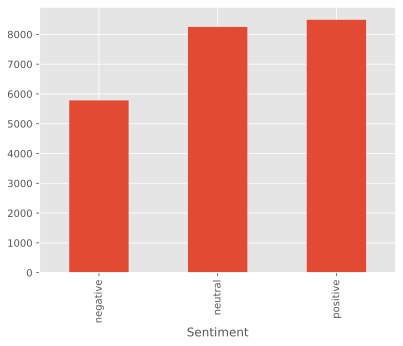

In [8]:
print(df_org['Sentiment'].value_counts().sort_index())
df_org['Sentiment'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [9]:
# using regex to clean the tweets, removing usernames, urls, stopwords, etc.
def preprocess(text):
    text = re.sub(r'(^|\s)@(\w+)', r'\1@user', text)
    text = re.sub(r'\bhttps?://\S+\b', 'http', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text

In [21]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:
df_org['preprocessed_tweet'] = df_org['Tweet'].apply(preprocess)

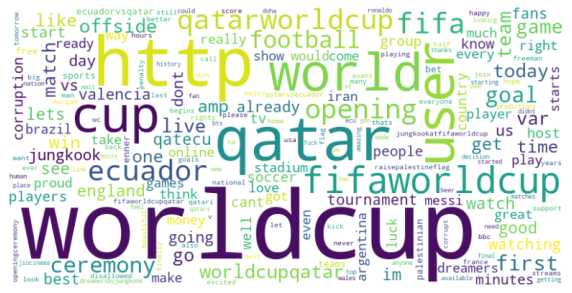

In [11]:
# Calculate word frequencies
word_freq = df_org['preprocessed_tweet'].str.split().explode().value_counts().reset_index()
word_freq.columns = ['Word', 'Frequency']
word_freq['Frequency'] = word_freq['Frequency'].astype(int)  # Convert frequency column to integers

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq.set_index('Word')['Frequency'].to_dict())

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
labels = df_org['Sentiment'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['neutral', 'negative', 'positive']

In [13]:
for key, value in enumerate(labels):
    print(value)

neutral
negative
positive


In [14]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [15]:
label2id

{'neutral': 0, 'negative': 1, 'positive': 2}

In [16]:
id2label

{0: 'neutral', 1: 'negative', 2: 'positive'}

In [17]:
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral,ecuador players losing qatar tonight fifaworld...
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative,morgan freeman old damn cant believe worldcup
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral,guess worldcup opener ahead governing bodies f...
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral,going hear user pundits talk usa regarding war...
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral,hattrick already qatecu worldcup
...,...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative,never felt unenthusiastic major sporting event...
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive,getting started first step start investment in...
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral,monday bargain bin worldcup begun lets see int...
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive,tomorrow usa plays wales world cup well openin...


In [18]:
df_org["labels"]=df_org['Sentiment'].map(lambda x: label2id[x.strip()])

In [19]:
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet,labels
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral,ecuador players losing qatar tonight fifaworld...,0
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative,morgan freeman old damn cant believe worldcup,1
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral,guess worldcup opener ahead governing bodies f...,0
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral,going hear user pundits talk usa regarding war...,0
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral,hattrick already qatecu worldcup,0
...,...,...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative,never felt unenthusiastic major sporting event...,1
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive,getting started first step start investment in...,2
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral,monday bargain bin worldcup begun lets see int...,0
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive,tomorrow usa plays wales world cup well openin...,2


<Axes: ylabel='count'>

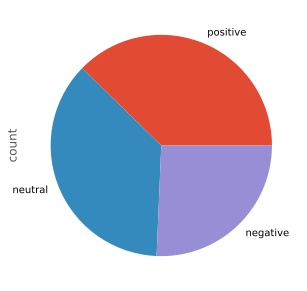

In [20]:
df_org['Sentiment'].value_counts().plot(kind='pie', figsize=(5,5))

In [22]:
# tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased", max_length=512)

In [23]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [24]:
# Splitting df_org

SIZE= df_org.shape[0]

train_texts= list(df_org.preprocessed_tweet[:SIZE//2])

val_texts=   list(df_org.preprocessed_tweet[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.preprocessed_tweet[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [25]:
len(train_texts)

11262

In [26]:
len(train_texts), len(val_texts), len(test_texts)

(11262, 5631, 5631)

In [27]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [28]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [29]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [30]:
# Training with Trainer Class
from transformers import TrainingArguments, Trainer

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [32]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./fifa22-tweet-distilbert-results',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 2.0
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./fifa22-tweet-distilbert-logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [33]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [34]:
torch.cuda.empty_cache()

In [35]:
trainer.train()

  0%|          | 10/2816 [00:02<07:07,  6.57it/s] 

{'loss': 1.0961, 'learning_rate': 5e-06, 'epoch': 0.01}


                                                 
  0%|          | 11/2816 [00:13<1:39:18,  2.12s/it]

{'eval_loss': 1.0972262620925903, 'eval_Accuracy': 0.3375954537382348, 'eval_F1': 0.2801610220030187, 'eval_Precision': 0.3011965067247458, 'eval_Recall': 0.30648227509042897, 'eval_runtime': 11.415, 'eval_samples_per_second': 493.297, 'eval_steps_per_second': 30.837, 'epoch': 0.01}


  1%|          | 20/2816 [00:14<23:49,  1.96it/s]  

{'loss': 1.1098, 'learning_rate': 1e-05, 'epoch': 0.01}


                                                 
  1%|          | 21/2816 [00:26<1:40:10,  2.15s/it]

{'eval_loss': 1.0918784141540527, 'eval_Accuracy': 0.3814597762386787, 'eval_F1': 0.1908997961804905, 'eval_Precision': 0.38889741818274864, 'eval_Recall': 0.33529417504082737, 'eval_runtime': 11.528, 'eval_samples_per_second': 488.463, 'eval_steps_per_second': 30.534, 'epoch': 0.01}


  1%|          | 30/2816 [00:26<26:10,  1.77it/s]  

{'loss': 1.0888, 'learning_rate': 1.5e-05, 'epoch': 0.02}


                                                 
  1%|          | 31/2816 [00:38<1:40:55,  2.17s/it]

{'eval_loss': 1.0824906826019287, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 11.659, 'eval_samples_per_second': 482.976, 'eval_steps_per_second': 30.191, 'epoch': 0.02}


  1%|▏         | 40/2816 [00:39<26:47,  1.73it/s]  

{'loss': 1.0889, 'learning_rate': 2e-05, 'epoch': 0.03}


                                                 
  1%|▏         | 41/2816 [00:51<1:40:16,  2.17s/it]

{'eval_loss': 1.068718433380127, 'eval_Accuracy': 0.38021665778724917, 'eval_F1': 0.18524093504387865, 'eval_Precision': 0.6599703703703704, 'eval_Recall': 0.33404036510152363, 'eval_runtime': 11.586, 'eval_samples_per_second': 486.018, 'eval_steps_per_second': 30.381, 'epoch': 0.03}


  2%|▏         | 50/2816 [00:51<26:34,  1.73it/s]  

{'loss': 1.0646, 'learning_rate': 2.5e-05, 'epoch': 0.04}


                                                 
  2%|▏         | 51/2816 [01:03<1:41:02,  2.19s/it]

{'eval_loss': 1.046709418296814, 'eval_Accuracy': 0.42479133368851, 'eval_F1': 0.30367354063931984, 'eval_Precision': 0.5807059304519684, 'eval_Recall': 0.395731022086461, 'eval_runtime': 11.764, 'eval_samples_per_second': 478.663, 'eval_steps_per_second': 29.922, 'epoch': 0.04}


  2%|▏         | 60/2816 [01:04<26:48,  1.71it/s]  

{'loss': 1.0696, 'learning_rate': 3e-05, 'epoch': 0.04}


                                                 
  2%|▏         | 61/2816 [01:15<1:39:54,  2.18s/it]

{'eval_loss': 1.0116236209869385, 'eval_Accuracy': 0.5176700408453205, 'eval_F1': 0.4742108718366504, 'eval_Precision': 0.5873076212041582, 'eval_Recall': 0.5024455340558972, 'eval_runtime': 11.624, 'eval_samples_per_second': 484.43, 'eval_steps_per_second': 30.282, 'epoch': 0.04}


  2%|▏         | 70/2816 [01:16<26:30,  1.73it/s]  

{'loss': 0.988, 'learning_rate': 3.5e-05, 'epoch': 0.05}


                                                 
  3%|▎         | 71/2816 [01:28<1:38:19,  2.15s/it]

{'eval_loss': 0.9969978332519531, 'eval_Accuracy': 0.4853489611081513, 'eval_F1': 0.36045717560018176, 'eval_Precision': 0.6209805326926942, 'eval_Recall': 0.431826170531578, 'eval_runtime': 11.47, 'eval_samples_per_second': 490.932, 'eval_steps_per_second': 30.689, 'epoch': 0.05}


  3%|▎         | 80/2816 [01:28<26:03,  1.75it/s]  

{'loss': 1.0139, 'learning_rate': 4e-05, 'epoch': 0.06}


                                                 
  3%|▎         | 81/2816 [01:40<1:39:22,  2.18s/it]

{'eval_loss': 0.9288743138313293, 'eval_Accuracy': 0.6309714082756172, 'eval_F1': 0.6323327948256865, 'eval_Precision': 0.6414994967242112, 'eval_Recall': 0.6496917069168244, 'eval_runtime': 11.703, 'eval_samples_per_second': 481.157, 'eval_steps_per_second': 30.078, 'epoch': 0.06}


  3%|▎         | 90/2816 [01:41<26:23,  1.72it/s]  

{'loss': 0.9411, 'learning_rate': 4.5e-05, 'epoch': 0.06}


                                                 
  3%|▎         | 93/2816 [01:53<1:09:45,  1.54s/it]

{'eval_loss': 0.8814188241958618, 'eval_Accuracy': 0.5787604333155745, 'eval_F1': 0.553315693612087, 'eval_Precision': 0.6712535068933226, 'eval_Recall': 0.5720095492736772, 'eval_runtime': 11.565, 'eval_samples_per_second': 486.899, 'eval_steps_per_second': 30.437, 'epoch': 0.06}


  4%|▎         | 100/2816 [01:53<26:00,  1.74it/s] 

{'loss': 0.9665, 'learning_rate': 5e-05, 'epoch': 0.07}


                                                  
  4%|▎         | 101/2816 [02:04<1:36:00,  2.12s/it]

{'eval_loss': 0.8223993182182312, 'eval_Accuracy': 0.631681761676434, 'eval_F1': 0.6323253971288548, 'eval_Precision': 0.6738142365535763, 'eval_Recall': 0.646579732970914, 'eval_runtime': 11.308, 'eval_samples_per_second': 497.968, 'eval_steps_per_second': 31.129, 'epoch': 0.07}


  4%|▍         | 110/2816 [02:05<25:32,  1.77it/s]  

{'loss': 0.7855, 'learning_rate': 4.9815905743740795e-05, 'epoch': 0.08}


                                                  
  4%|▍         | 111/2816 [02:17<1:35:38,  2.12s/it]

{'eval_loss': 0.7932780385017395, 'eval_Accuracy': 0.6389628840348073, 'eval_F1': 0.6421553826704812, 'eval_Precision': 0.6734224755476701, 'eval_Recall': 0.6516405664536277, 'eval_runtime': 11.342, 'eval_samples_per_second': 496.473, 'eval_steps_per_second': 31.035, 'epoch': 0.08}


  4%|▍         | 120/2816 [02:17<25:27,  1.77it/s]  

{'loss': 0.8113, 'learning_rate': 4.9631811487481595e-05, 'epoch': 0.09}


                                                  
  4%|▍         | 123/2816 [02:29<1:07:23,  1.50s/it]

{'eval_loss': 0.802082896232605, 'eval_Accuracy': 0.6403835908364411, 'eval_F1': 0.6239775545371886, 'eval_Precision': 0.6635890343315595, 'eval_Recall': 0.6605322503711176, 'eval_runtime': 11.3, 'eval_samples_per_second': 498.319, 'eval_steps_per_second': 31.15, 'epoch': 0.09}


  5%|▍         | 130/2816 [02:29<25:09,  1.78it/s]  

{'loss': 0.7974, 'learning_rate': 4.944771723122239e-05, 'epoch': 0.09}


                                                  
  5%|▍         | 131/2816 [02:41<1:34:19,  2.11s/it]

{'eval_loss': 0.7902131080627441, 'eval_Accuracy': 0.6773219676789203, 'eval_F1': 0.6746458376924488, 'eval_Precision': 0.7053217877551036, 'eval_Recall': 0.6655037194407958, 'eval_runtime': 11.276, 'eval_samples_per_second': 499.379, 'eval_steps_per_second': 31.217, 'epoch': 0.09}


  5%|▍         | 140/2816 [02:41<25:00,  1.78it/s]  

{'loss': 0.8263, 'learning_rate': 4.926362297496319e-05, 'epoch': 0.1}


                                                  
  5%|▌         | 141/2816 [02:53<1:34:01,  2.11s/it]

{'eval_loss': 0.7371639609336853, 'eval_Accuracy': 0.6814064997336174, 'eval_F1': 0.681026645690595, 'eval_Precision': 0.6815568951595532, 'eval_Recall': 0.6881503439271318, 'eval_runtime': 11.289, 'eval_samples_per_second': 498.805, 'eval_steps_per_second': 31.181, 'epoch': 0.1}


  5%|▌         | 150/2816 [02:53<24:55,  1.78it/s]  

{'loss': 0.9578, 'learning_rate': 4.907952871870398e-05, 'epoch': 0.11}


                                                  
  5%|▌         | 151/2816 [03:05<1:34:17,  2.12s/it]

{'eval_loss': 0.7631897330284119, 'eval_Accuracy': 0.6821168531344344, 'eval_F1': 0.6832161612261668, 'eval_Precision': 0.7253436344234601, 'eval_Recall': 0.6816191135642183, 'eval_runtime': 11.381, 'eval_samples_per_second': 494.772, 'eval_steps_per_second': 30.929, 'epoch': 0.11}


  6%|▌         | 160/2816 [03:05<24:59,  1.77it/s]  

{'loss': 0.7328, 'learning_rate': 4.889543446244477e-05, 'epoch': 0.11}


                                                  
  6%|▌         | 163/2816 [03:17<1:06:24,  1.50s/it]

{'eval_loss': 0.7512611746788025, 'eval_Accuracy': 0.6640028414136032, 'eval_F1': 0.6565602676123649, 'eval_Precision': 0.6773220964222713, 'eval_Recall': 0.6723067777893431, 'eval_runtime': 11.308, 'eval_samples_per_second': 497.966, 'eval_steps_per_second': 31.128, 'epoch': 0.11}


  6%|▌         | 170/2816 [03:17<24:48,  1.78it/s]  

{'loss': 0.7311, 'learning_rate': 4.871134020618557e-05, 'epoch': 0.12}


                                                  
  6%|▌         | 173/2816 [03:29<1:06:04,  1.50s/it]

{'eval_loss': 0.7700218558311462, 'eval_Accuracy': 0.6711063754217723, 'eval_F1': 0.671991822894602, 'eval_Precision': 0.6814814595065118, 'eval_Recall': 0.6883845779051292, 'eval_runtime': 11.303, 'eval_samples_per_second': 498.186, 'eval_steps_per_second': 31.142, 'epoch': 0.12}


  6%|▋         | 180/2816 [03:30<24:41,  1.78it/s]  

{'loss': 0.6819, 'learning_rate': 4.8527245949926364e-05, 'epoch': 0.13}


                                                  
  6%|▋         | 181/2816 [03:41<1:32:49,  2.11s/it]

{'eval_loss': 0.7353262305259705, 'eval_Accuracy': 0.6908186822944414, 'eval_F1': 0.6878376154533768, 'eval_Precision': 0.7139589746328894, 'eval_Recall': 0.6778896514031653, 'eval_runtime': 11.316, 'eval_samples_per_second': 497.613, 'eval_steps_per_second': 31.106, 'epoch': 0.13}


  7%|▋         | 190/2816 [03:42<24:36,  1.78it/s]  

{'loss': 0.9081, 'learning_rate': 4.834315169366716e-05, 'epoch': 0.13}


                                                  
  7%|▋         | 191/2816 [03:53<1:32:27,  2.11s/it]

{'eval_loss': 0.7481239438056946, 'eval_Accuracy': 0.6723494938732019, 'eval_F1': 0.6660132427834483, 'eval_Precision': 0.7036860046369298, 'eval_Recall': 0.6702768515244514, 'eval_runtime': 11.312, 'eval_samples_per_second': 497.791, 'eval_steps_per_second': 31.117, 'epoch': 0.13}


  7%|▋         | 200/2816 [03:54<24:30,  1.78it/s]  

{'loss': 0.7452, 'learning_rate': 4.8159057437407956e-05, 'epoch': 0.14}


                                                  
  7%|▋         | 201/2816 [04:05<1:32:10,  2.11s/it]

{'eval_loss': 0.6931132674217224, 'eval_Accuracy': 0.7052033386609838, 'eval_F1': 0.7075487712628487, 'eval_Precision': 0.7053706312743047, 'eval_Recall': 0.7121820867119557, 'eval_runtime': 11.322, 'eval_samples_per_second': 497.35, 'eval_steps_per_second': 31.09, 'epoch': 0.14}


  7%|▋         | 210/2816 [04:06<24:25,  1.78it/s]  

{'loss': 0.7568, 'learning_rate': 4.797496318114875e-05, 'epoch': 0.15}


                                                  
  8%|▊         | 213/2816 [04:17<1:05:07,  1.50s/it]

{'eval_loss': 0.7271916270256042, 'eval_Accuracy': 0.6773219676789203, 'eval_F1': 0.6699513764730751, 'eval_Precision': 0.6957118009047281, 'eval_Recall': 0.6769532163002004, 'eval_runtime': 11.316, 'eval_samples_per_second': 497.614, 'eval_steps_per_second': 31.106, 'epoch': 0.15}


  8%|▊         | 220/2816 [04:18<24:19,  1.78it/s]  

{'loss': 0.7454, 'learning_rate': 4.779086892488955e-05, 'epoch': 0.16}


                                                  
  8%|▊         | 223/2816 [04:29<1:04:55,  1.50s/it]

{'eval_loss': 0.6968869566917419, 'eval_Accuracy': 0.7023619250577162, 'eval_F1': 0.7041685367530705, 'eval_Precision': 0.701745251391205, 'eval_Recall': 0.7147565082502864, 'eval_runtime': 11.326, 'eval_samples_per_second': 497.176, 'eval_steps_per_second': 31.079, 'epoch': 0.16}


  8%|▊         | 230/2816 [04:30<24:15,  1.78it/s]  

{'loss': 0.8183, 'learning_rate': 4.760677466863034e-05, 'epoch': 0.16}


                                                  
  8%|▊         | 233/2816 [04:41<1:04:41,  1.50s/it]

{'eval_loss': 0.7318079471588135, 'eval_Accuracy': 0.6821168531344344, 'eval_F1': 0.6846619302090593, 'eval_Precision': 0.6951193379158761, 'eval_Recall': 0.7011460645759217, 'eval_runtime': 11.327, 'eval_samples_per_second': 497.131, 'eval_steps_per_second': 31.076, 'epoch': 0.16}


  9%|▊         | 240/2816 [04:42<24:09,  1.78it/s]  

{'loss': 0.7811, 'learning_rate': 4.7422680412371134e-05, 'epoch': 0.17}


                                                  
  9%|▊         | 241/2816 [04:53<1:30:57,  2.12s/it]

{'eval_loss': 0.6745598316192627, 'eval_Accuracy': 0.7119516959687444, 'eval_F1': 0.7114281869793989, 'eval_Precision': 0.7095582765428962, 'eval_Recall': 0.7200336344102377, 'eval_runtime': 11.35, 'eval_samples_per_second': 496.122, 'eval_steps_per_second': 31.013, 'epoch': 0.17}


  9%|▉         | 250/2816 [04:54<24:05,  1.77it/s]  

{'loss': 0.5943, 'learning_rate': 4.723858615611193e-05, 'epoch': 0.18}


                                                  
  9%|▉         | 251/2816 [05:05<1:30:34,  2.12s/it]

{'eval_loss': 0.6815199255943298, 'eval_Accuracy': 0.707689575563843, 'eval_F1': 0.711037566686211, 'eval_Precision': 0.721713363712423, 'eval_Recall': 0.7117315959270482, 'eval_runtime': 11.342, 'eval_samples_per_second': 496.473, 'eval_steps_per_second': 31.035, 'epoch': 0.18}


  9%|▉         | 260/2816 [05:06<24:00,  1.77it/s]  

{'loss': 0.7645, 'learning_rate': 4.7054491899852726e-05, 'epoch': 0.18}


                                                  
  9%|▉         | 261/2816 [05:17<1:30:15,  2.12s/it]

{'eval_loss': 0.6707553863525391, 'eval_Accuracy': 0.7133724027703783, 'eval_F1': 0.7140569112305727, 'eval_Precision': 0.7176132389833185, 'eval_Recall': 0.7113118527846215, 'eval_runtime': 11.348, 'eval_samples_per_second': 496.211, 'eval_steps_per_second': 31.019, 'epoch': 0.18}


 10%|▉         | 270/2816 [05:18<23:55,  1.77it/s]  

{'loss': 0.8644, 'learning_rate': 4.687039764359352e-05, 'epoch': 0.19}


                                                  
 10%|▉         | 271/2816 [05:29<1:29:55,  2.12s/it]

{'eval_loss': 0.7696573138237, 'eval_Accuracy': 0.6476647131948144, 'eval_F1': 0.6195786208612384, 'eval_Precision': 0.6911467941364476, 'eval_Recall': 0.664999713936785, 'eval_runtime': 11.349, 'eval_samples_per_second': 496.167, 'eval_steps_per_second': 31.016, 'epoch': 0.19}


 10%|▉         | 280/2816 [05:30<23:50,  1.77it/s]  

{'loss': 0.7149, 'learning_rate': 4.668630338733432e-05, 'epoch': 0.2}


                                                  
 10%|▉         | 281/2816 [05:42<1:29:33,  2.12s/it]

{'eval_loss': 0.7424441576004028, 'eval_Accuracy': 0.6774995560291245, 'eval_F1': 0.6774302533608182, 'eval_Precision': 0.6931177768232586, 'eval_Recall': 0.7021650420635668, 'eval_runtime': 11.346, 'eval_samples_per_second': 496.297, 'eval_steps_per_second': 31.024, 'epoch': 0.2}


 10%|█         | 290/2816 [05:42<23:43,  1.77it/s]  

{'loss': 0.8326, 'learning_rate': 4.650220913107511e-05, 'epoch': 0.21}


                                                  
 10%|█         | 293/2816 [05:54<1:03:19,  1.51s/it]

{'eval_loss': 0.7037876844406128, 'eval_Accuracy': 0.7044929852601669, 'eval_F1': 0.7052233334292191, 'eval_Precision': 0.7244129489740168, 'eval_Recall': 0.7004162857296103, 'eval_runtime': 11.354, 'eval_samples_per_second': 495.948, 'eval_steps_per_second': 31.002, 'epoch': 0.21}


 11%|█         | 300/2816 [05:54<23:38,  1.77it/s]  

{'loss': 0.6572, 'learning_rate': 4.631811487481591e-05, 'epoch': 0.21}


                                                  
 11%|█         | 301/2816 [06:06<1:28:49,  2.12s/it]

{'eval_loss': 0.6922558546066284, 'eval_Accuracy': 0.6993429231042444, 'eval_F1': 0.6987251664008419, 'eval_Precision': 0.6989535274551487, 'eval_Recall': 0.7140335441312903, 'eval_runtime': 11.342, 'eval_samples_per_second': 496.473, 'eval_steps_per_second': 31.035, 'epoch': 0.21}


 11%|█         | 310/2816 [06:06<23:32,  1.77it/s]  

{'loss': 0.6397, 'learning_rate': 4.61340206185567e-05, 'epoch': 0.22}


                                                  
 11%|█         | 313/2816 [06:18<1:02:49,  1.51s/it]

{'eval_loss': 0.7123129367828369, 'eval_Accuracy': 0.7062688687622092, 'eval_F1': 0.7027642664308266, 'eval_Precision': 0.7097943364781528, 'eval_Recall': 0.7102421370893438, 'eval_runtime': 11.352, 'eval_samples_per_second': 496.036, 'eval_steps_per_second': 31.008, 'epoch': 0.22}


 11%|█▏        | 320/2816 [06:18<23:27,  1.77it/s]  

{'loss': 0.7744, 'learning_rate': 4.5949926362297496e-05, 'epoch': 0.23}


                                                  
 11%|█▏        | 323/2816 [06:30<1:02:34,  1.51s/it]

{'eval_loss': 0.6724250912666321, 'eval_Accuracy': 0.7204759367785474, 'eval_F1': 0.7205122512661992, 'eval_Precision': 0.7177138109269351, 'eval_Recall': 0.7254443123591064, 'eval_runtime': 11.351, 'eval_samples_per_second': 496.08, 'eval_steps_per_second': 31.01, 'epoch': 0.23}


 12%|█▏        | 330/2816 [06:31<23:21,  1.77it/s]  

{'loss': 0.629, 'learning_rate': 4.5765832106038295e-05, 'epoch': 0.23}


                                                  
 12%|█▏        | 331/2816 [06:42<1:28:48,  2.14s/it]

{'eval_loss': 0.6889353394508362, 'eval_Accuracy': 0.7176345231752796, 'eval_F1': 0.7157429199016665, 'eval_Precision': 0.7332474710412836, 'eval_Recall': 0.7075359055363079, 'eval_runtime': 11.506, 'eval_samples_per_second': 489.396, 'eval_steps_per_second': 30.593, 'epoch': 0.23}


 12%|█▏        | 340/2816 [06:43<23:40,  1.74it/s]  

{'loss': 0.8497, 'learning_rate': 4.558173784977909e-05, 'epoch': 0.24}


                                                  
 12%|█▏        | 341/2816 [06:55<1:31:43,  2.22s/it]

{'eval_loss': 0.703589677810669, 'eval_Accuracy': 0.695968744450364, 'eval_F1': 0.6837476753757296, 'eval_Precision': 0.7412314840347225, 'eval_Recall': 0.6730015510054416, 'eval_runtime': 11.984, 'eval_samples_per_second': 469.877, 'eval_steps_per_second': 29.373, 'epoch': 0.24}


 12%|█▏        | 350/2816 [06:56<24:12,  1.70it/s]  

{'loss': 0.6825, 'learning_rate': 4.539764359351989e-05, 'epoch': 0.25}


                                                  
 12%|█▏        | 351/2816 [07:07<1:28:48,  2.16s/it]

{'eval_loss': 0.7061914205551147, 'eval_Accuracy': 0.6908186822944414, 'eval_F1': 0.6773233300311808, 'eval_Precision': 0.7294341839300845, 'eval_Recall': 0.6671214103603219, 'eval_runtime': 11.4955, 'eval_samples_per_second': 489.844, 'eval_steps_per_second': 30.621, 'epoch': 0.25}


 13%|█▎        | 360/2816 [07:08<23:35,  1.74it/s]  

{'loss': 0.7132, 'learning_rate': 4.521354933726068e-05, 'epoch': 0.26}


                                                  
 13%|█▎        | 361/2816 [07:19<1:28:26,  2.16s/it]

{'eval_loss': 0.6864044666290283, 'eval_Accuracy': 0.7101758124667021, 'eval_F1': 0.7107405901595798, 'eval_Precision': 0.7223689347382564, 'eval_Recall': 0.70771580591478, 'eval_runtime': 11.5606, 'eval_samples_per_second': 487.084, 'eval_steps_per_second': 30.448, 'epoch': 0.26}


 13%|█▎        | 370/2816 [07:20<23:30,  1.73it/s]  

{'loss': 0.7123, 'learning_rate': 4.502945508100147e-05, 'epoch': 0.26}


                                                  
 13%|█▎        | 371/2816 [07:32<1:27:36,  2.15s/it]

{'eval_loss': 0.6857226490974426, 'eval_Accuracy': 0.7044929852601669, 'eval_F1': 0.7012850530433976, 'eval_Precision': 0.717463762714868, 'eval_Recall': 0.7067757083350038, 'eval_runtime': 11.482, 'eval_samples_per_second': 490.42, 'eval_steps_per_second': 30.657, 'epoch': 0.26}


 13%|█▎        | 380/2816 [07:32<23:12,  1.75it/s]  

{'loss': 0.6617, 'learning_rate': 4.484536082474227e-05, 'epoch': 0.27}


                                                  
 14%|█▎        | 381/2816 [07:44<1:29:29,  2.21s/it]

{'eval_loss': 0.6523439288139343, 'eval_Accuracy': 0.7167465814242586, 'eval_F1': 0.7182423832678094, 'eval_Precision': 0.7233405539282275, 'eval_Recall': 0.7154373511877411, 'eval_runtime': 11.876, 'eval_samples_per_second': 474.15, 'eval_steps_per_second': 29.64, 'epoch': 0.27}


 14%|█▍        | 390/2816 [07:45<23:38,  1.71it/s]  

{'loss': 0.6357, 'learning_rate': 4.4661266568483065e-05, 'epoch': 0.28}


                                                  
 14%|█▍        | 391/2816 [07:57<1:27:57,  2.18s/it]

{'eval_loss': 0.7171391844749451, 'eval_Accuracy': 0.7062688687622092, 'eval_F1': 0.7001253756525435, 'eval_Precision': 0.7498176664090348, 'eval_Recall': 0.6878527394608085, 'eval_runtime': 11.623, 'eval_samples_per_second': 484.469, 'eval_steps_per_second': 30.285, 'epoch': 0.28}


 14%|█▍        | 400/2816 [07:57<23:15,  1.73it/s]  

{'loss': 0.8309, 'learning_rate': 4.447717231222386e-05, 'epoch': 0.28}


                                                  
 14%|█▍        | 401/2816 [08:09<1:28:46,  2.21s/it]

{'eval_loss': 0.6501883864402771, 'eval_Accuracy': 0.7250932338838573, 'eval_F1': 0.7263428760565493, 'eval_Precision': 0.7322178103797369, 'eval_Recall': 0.7224076509693989, 'eval_runtime': 11.85, 'eval_samples_per_second': 475.191, 'eval_steps_per_second': 29.705, 'epoch': 0.28}


 15%|█▍        | 410/2816 [08:10<23:38,  1.70it/s]  

{'loss': 0.7519, 'learning_rate': 4.429307805596466e-05, 'epoch': 0.29}


                                                  
 15%|█▍        | 413/2816 [08:22<1:01:09,  1.53s/it]

{'eval_loss': 0.6762177348136902, 'eval_Accuracy': 0.7041378085597585, 'eval_F1': 0.7007489373013381, 'eval_Precision': 0.7171928344575972, 'eval_Recall': 0.7015897084666131, 'eval_runtime': 11.429, 'eval_samples_per_second': 492.694, 'eval_steps_per_second': 30.799, 'epoch': 0.29}


 15%|█▍        | 420/2816 [08:22<22:48,  1.75it/s]  

{'loss': 0.7639, 'learning_rate': 4.410898379970545e-05, 'epoch': 0.3}


                                                  
 15%|█▍        | 421/2816 [08:34<1:25:11,  2.13s/it]

{'eval_loss': 0.7458639740943909, 'eval_Accuracy': 0.678742674480554, 'eval_F1': 0.6648690014699022, 'eval_Precision': 0.7279258376204853, 'eval_Recall': 0.6560624830627774, 'eval_runtime': 11.407, 'eval_samples_per_second': 493.644, 'eval_steps_per_second': 30.858, 'epoch': 0.3}


 15%|█▌        | 430/2816 [08:34<22:33,  1.76it/s]  

{'loss': 0.802, 'learning_rate': 4.392488954344625e-05, 'epoch': 0.31}


                                                  
 15%|█▌        | 433/2816 [08:46<1:00:06,  1.51s/it]

{'eval_loss': 0.6471628546714783, 'eval_Accuracy': 0.723317350381815, 'eval_F1': 0.7255522249509697, 'eval_Precision': 0.734744970554479, 'eval_Recall': 0.722399822244011, 'eval_runtime': 11.407, 'eval_samples_per_second': 493.645, 'eval_steps_per_second': 30.858, 'epoch': 0.31}


 16%|█▌        | 440/2816 [08:46<22:26,  1.76it/s]  

{'loss': 0.6873, 'learning_rate': 4.374079528718704e-05, 'epoch': 0.31}


                                                  
 16%|█▌        | 441/2816 [08:58<1:24:23,  2.13s/it]

{'eval_loss': 0.6696841716766357, 'eval_Accuracy': 0.7014739833066951, 'eval_F1': 0.6997567436812103, 'eval_Precision': 0.6985598184708444, 'eval_Recall': 0.7140023896409966, 'eval_runtime': 11.411, 'eval_samples_per_second': 493.471, 'eval_steps_per_second': 30.847, 'epoch': 0.31}


 16%|█▌        | 450/2816 [08:59<22:21,  1.76it/s]  

{'loss': 0.6609, 'learning_rate': 4.3556701030927835e-05, 'epoch': 0.32}


                                                  
 16%|█▌        | 451/2816 [09:10<1:24:01,  2.13s/it]

{'eval_loss': 0.6524145603179932, 'eval_Accuracy': 0.7101758124667021, 'eval_F1': 0.7113821315643821, 'eval_Precision': 0.7097445664324814, 'eval_Recall': 0.7236025216226386, 'eval_runtime': 11.412, 'eval_samples_per_second': 493.428, 'eval_steps_per_second': 30.845, 'epoch': 0.32}


 16%|█▋        | 460/2816 [09:11<22:15,  1.76it/s]  

{'loss': 0.7098, 'learning_rate': 4.3372606774668634e-05, 'epoch': 0.33}


                                                  
 16%|█▋        | 463/2816 [09:22<59:31,  1.52s/it]  

{'eval_loss': 0.6624504923820496, 'eval_Accuracy': 0.7190552299769135, 'eval_F1': 0.7208961477762114, 'eval_Precision': 0.7212038665525887, 'eval_Recall': 0.7301695894052723, 'eval_runtime': 11.451, 'eval_samples_per_second': 491.747, 'eval_steps_per_second': 30.74, 'epoch': 0.33}


 17%|█▋        | 470/2816 [09:23<22:13,  1.76it/s]

{'loss': 0.6877, 'learning_rate': 4.318851251840943e-05, 'epoch': 0.33}


                                                  
 17%|█▋        | 471/2816 [09:34<1:23:25,  2.13s/it]

{'eval_loss': 0.6413838267326355, 'eval_Accuracy': 0.7215414668797727, 'eval_F1': 0.7223343422279985, 'eval_Precision': 0.7340308233769735, 'eval_Recall': 0.7162073888155028, 'eval_runtime': 11.423, 'eval_samples_per_second': 492.953, 'eval_steps_per_second': 30.815, 'epoch': 0.33}


 17%|█▋        | 480/2816 [09:35<22:11,  1.75it/s]  

{'loss': 0.708, 'learning_rate': 4.3004418262150226e-05, 'epoch': 0.34}


                                                  
 17%|█▋        | 481/2816 [09:47<1:23:29,  2.15s/it]

{'eval_loss': 0.6375516057014465, 'eval_Accuracy': 0.7254484105842657, 'eval_F1': 0.7273467041557301, 'eval_Precision': 0.7339340522711697, 'eval_Recall': 0.7229213517255633, 'eval_runtime': 11.48, 'eval_samples_per_second': 490.504, 'eval_steps_per_second': 30.662, 'epoch': 0.34}


 17%|█▋        | 490/2816 [09:47<22:06,  1.75it/s]  

{'loss': 0.6066, 'learning_rate': 4.282032400589102e-05, 'epoch': 0.35}


                                                  
 17%|█▋        | 491/2816 [09:59<1:23:43,  2.16s/it]

{'eval_loss': 0.6886635422706604, 'eval_Accuracy': 0.7103534008169065, 'eval_F1': 0.7134628620735474, 'eval_Precision': 0.7251388836298401, 'eval_Recall': 0.7215843467520843, 'eval_runtime': 11.587, 'eval_samples_per_second': 485.976, 'eval_steps_per_second': 30.379, 'epoch': 0.35}


 18%|█▊        | 500/2816 [10:00<22:11,  1.74it/s]  

{'loss': 0.651, 'learning_rate': 4.263622974963181e-05, 'epoch': 0.36}


                                                  
 18%|█▊        | 500/2816 [10:11<22:11,  1.74it/s]

{'eval_loss': 0.6373821496963501, 'eval_Accuracy': 0.7336174746936601, 'eval_F1': 0.7349280883067927, 'eval_Precision': 0.735404642452039, 'eval_Recall': 0.7346369826058434, 'eval_runtime': 11.725, 'eval_samples_per_second': 480.255, 'eval_steps_per_second': 30.021, 'epoch': 0.36}


 18%|█▊        | 510/2816 [10:16<20:50,  1.84it/s]  

{'loss': 0.6378, 'learning_rate': 4.245213549337261e-05, 'epoch': 0.36}


                                                  
 18%|█▊        | 512/2816 [10:27<1:22:44,  2.15s/it]

{'eval_loss': 0.6598539352416992, 'eval_Accuracy': 0.7211862901793642, 'eval_F1': 0.7219679048974563, 'eval_Precision': 0.7456997449720492, 'eval_Recall': 0.7142950898188234, 'eval_runtime': 11.409, 'eval_samples_per_second': 493.558, 'eval_steps_per_second': 30.853, 'epoch': 0.36}


 18%|█▊        | 520/2816 [10:28<21:32,  1.78it/s]  

{'loss': 0.5336, 'learning_rate': 4.2268041237113404e-05, 'epoch': 0.37}


                                                  
 19%|█▊        | 522/2816 [10:40<1:21:19,  2.13s/it]

{'eval_loss': 0.6519155502319336, 'eval_Accuracy': 0.7266915290356952, 'eval_F1': 0.7263179657931284, 'eval_Precision': 0.7413897371686508, 'eval_Recall': 0.7185771163839645, 'eval_runtime': 11.354, 'eval_samples_per_second': 495.949, 'eval_steps_per_second': 31.002, 'epoch': 0.37}


 19%|█▉        | 530/2816 [10:40<21:29,  1.77it/s]  

{'loss': 0.7259, 'learning_rate': 4.2083946980854196e-05, 'epoch': 0.38}


                                                  
 19%|█▉        | 532/2816 [10:52<1:20:50,  2.12s/it]

{'eval_loss': 0.6480650901794434, 'eval_Accuracy': 0.7281122358373291, 'eval_F1': 0.7285506615222511, 'eval_Precision': 0.7254651960313471, 'eval_Recall': 0.7337794898399309, 'eval_runtime': 11.364, 'eval_samples_per_second': 495.512, 'eval_steps_per_second': 30.975, 'epoch': 0.38}


 19%|█▉        | 540/2816 [10:52<21:24,  1.77it/s]  

{'loss': 0.679, 'learning_rate': 4.1899852724594996e-05, 'epoch': 0.38}


                                                  
 19%|█▉        | 542/2816 [11:04<1:20:32,  2.12s/it]

{'eval_loss': 0.6387578845024109, 'eval_Accuracy': 0.7270467057361037, 'eval_F1': 0.728024982232609, 'eval_Precision': 0.7290162607602756, 'eval_Recall': 0.7274531511040289, 'eval_runtime': 11.377, 'eval_samples_per_second': 494.946, 'eval_steps_per_second': 30.94, 'epoch': 0.38}


 20%|█▉        | 550/2816 [11:04<21:21,  1.77it/s]  

{'loss': 0.6332, 'learning_rate': 4.171575846833579e-05, 'epoch': 0.39}


                                                  
 20%|█▉        | 552/2816 [11:16<1:21:46,  2.17s/it]

{'eval_loss': 0.6513197422027588, 'eval_Accuracy': 0.72100870182916, 'eval_F1': 0.7222192954785364, 'eval_Precision': 0.7351156348033498, 'eval_Recall': 0.715370725599477, 'eval_runtime': 11.644, 'eval_samples_per_second': 483.597, 'eval_steps_per_second': 30.23, 'epoch': 0.39}


 20%|█▉        | 560/2816 [11:17<21:44,  1.73it/s]  

{'loss': 0.7024, 'learning_rate': 4.153166421207659e-05, 'epoch': 0.4}


                                                  
 20%|█▉        | 562/2816 [11:29<1:22:17,  2.19s/it]

{'eval_loss': 0.6463648080825806, 'eval_Accuracy': 0.7195879950275262, 'eval_F1': 0.7214532545745923, 'eval_Precision': 0.7192932604285519, 'eval_Recall': 0.7252982442596392, 'eval_runtime': 11.749, 'eval_samples_per_second': 479.275, 'eval_steps_per_second': 29.96, 'epoch': 0.4}


 20%|██        | 570/2816 [11:29<21:50,  1.71it/s]  

{'loss': 0.6981, 'learning_rate': 4.134756995581738e-05, 'epoch': 0.4}


                                                  
 20%|██        | 573/2816 [11:41<1:04:16,  1.72s/it]

{'eval_loss': 0.6717514991760254, 'eval_Accuracy': 0.7172793464748712, 'eval_F1': 0.7172669903532164, 'eval_Precision': 0.7396702371820111, 'eval_Recall': 0.7076934850480995, 'eval_runtime': 11.64, 'eval_samples_per_second': 483.763, 'eval_steps_per_second': 30.241, 'epoch': 0.4}


 21%|██        | 580/2816 [11:42<22:14,  1.68it/s]  

{'loss': 0.6505, 'learning_rate': 4.1163475699558173e-05, 'epoch': 0.41}


                                                  
 21%|██        | 583/2816 [11:53<57:41,  1.55s/it]  

{'eval_loss': 0.6539396047592163, 'eval_Accuracy': 0.7242052921328361, 'eval_F1': 0.7255960350287544, 'eval_Precision': 0.7504394476901547, 'eval_Recall': 0.7159754643998483, 'eval_runtime': 11.454, 'eval_samples_per_second': 491.619, 'eval_steps_per_second': 30.732, 'epoch': 0.41}


 21%|██        | 590/2816 [11:54<21:18,  1.74it/s]

{'loss': 0.7418, 'learning_rate': 4.097938144329897e-05, 'epoch': 0.42}


                                                  
 21%|██        | 591/2816 [12:05<1:19:56,  2.16s/it]

{'eval_loss': 0.6293588280677795, 'eval_Accuracy': 0.7279346474871249, 'eval_F1': 0.7305779206048205, 'eval_Precision': 0.732919063898653, 'eval_Recall': 0.730352281955417, 'eval_runtime': 11.49, 'eval_samples_per_second': 490.078, 'eval_steps_per_second': 30.635, 'epoch': 0.42}


 21%|██▏       | 600/2816 [12:06<21:07,  1.75it/s]  

{'loss': 0.5669, 'learning_rate': 4.0795287187039766e-05, 'epoch': 0.43}


                                                  
 21%|██▏       | 601/2816 [12:18<1:19:21,  2.15s/it]

{'eval_loss': 0.6502338647842407, 'eval_Accuracy': 0.7254484105842657, 'eval_F1': 0.7260598811503853, 'eval_Precision': 0.7337446734853886, 'eval_Recall': 0.7209681479641055, 'eval_runtime': 11.496, 'eval_samples_per_second': 489.823, 'eval_steps_per_second': 30.619, 'epoch': 0.43}


 22%|██▏       | 610/2816 [12:18<21:05,  1.74it/s]  

{'loss': 0.5902, 'learning_rate': 4.061119293078056e-05, 'epoch': 0.43}


                                                  
 22%|██▏       | 613/2816 [12:30<55:56,  1.52s/it]  

{'eval_loss': 0.6568282842636108, 'eval_Accuracy': 0.7176345231752796, 'eval_F1': 0.7197439519309264, 'eval_Precision': 0.7176023308991436, 'eval_Recall': 0.7296620132694182, 'eval_runtime': 11.466, 'eval_samples_per_second': 491.104, 'eval_steps_per_second': 30.699, 'epoch': 0.43}


 22%|██▏       | 620/2816 [12:31<20:51,  1.75it/s]

{'loss': 0.6983, 'learning_rate': 4.042709867452136e-05, 'epoch': 0.44}


                                                  
 22%|██▏       | 621/2816 [12:42<1:18:24,  2.14s/it]

{'eval_loss': 0.6522842049598694, 'eval_Accuracy': 0.7217190552299769, 'eval_F1': 0.7244620554381376, 'eval_Precision': 0.7227182244989879, 'eval_Recall': 0.7317744767341935, 'eval_runtime': 11.468, 'eval_samples_per_second': 491.018, 'eval_steps_per_second': 30.694, 'epoch': 0.44}


 22%|██▏       | 630/2816 [12:43<20:51,  1.75it/s]  

{'loss': 0.5664, 'learning_rate': 4.024300441826215e-05, 'epoch': 0.45}


                                                  
 22%|██▏       | 631/2816 [12:54<1:17:49,  2.14s/it]

{'eval_loss': 0.6378775835037231, 'eval_Accuracy': 0.73823477179897, 'eval_F1': 0.7402940871798167, 'eval_Precision': 0.7437999268556088, 'eval_Recall': 0.7374677037698856, 'eval_runtime': 11.421, 'eval_samples_per_second': 493.039, 'eval_steps_per_second': 30.82, 'epoch': 0.45}


 23%|██▎       | 640/2816 [12:55<20:36,  1.76it/s]  

{'loss': 0.6213, 'learning_rate': 4.005891016200295e-05, 'epoch': 0.45}


                                                  
 23%|██▎       | 641/2816 [13:07<1:18:06,  2.15s/it]

{'eval_loss': 0.6435601711273193, 'eval_Accuracy': 0.7366364766471319, 'eval_F1': 0.737794792219639, 'eval_Precision': 0.7390243096960111, 'eval_Recall': 0.7384516238851643, 'eval_runtime': 11.554, 'eval_samples_per_second': 487.364, 'eval_steps_per_second': 30.466, 'epoch': 0.45}


 23%|██▎       | 650/2816 [13:07<20:43,  1.74it/s]  

{'loss': 0.6909, 'learning_rate': 3.987481590574374e-05, 'epoch': 0.46}


                                                  
 23%|██▎       | 651/2816 [13:19<1:18:39,  2.18s/it]

{'eval_loss': 0.6661887168884277, 'eval_Accuracy': 0.7217190552299769, 'eval_F1': 0.7219639913782556, 'eval_Precision': 0.7190058191028993, 'eval_Recall': 0.731559926783477, 'eval_runtime': 11.698, 'eval_samples_per_second': 481.364, 'eval_steps_per_second': 30.091, 'epoch': 0.46}


 23%|██▎       | 660/2816 [13:20<20:49,  1.72it/s]  

{'loss': 0.5328, 'learning_rate': 3.9690721649484535e-05, 'epoch': 0.47}


                                                  
 23%|██▎       | 661/2816 [13:31<1:18:05,  2.17s/it]

{'eval_loss': 0.6701877117156982, 'eval_Accuracy': 0.7274018824365122, 'eval_F1': 0.7271964735149806, 'eval_Precision': 0.7245533372570526, 'eval_Recall': 0.7331934668854396, 'eval_runtime': 11.628, 'eval_samples_per_second': 484.262, 'eval_steps_per_second': 30.272, 'epoch': 0.47}


 24%|██▍       | 670/2816 [13:32<20:38,  1.73it/s]  

{'loss': 0.6696, 'learning_rate': 3.9506627393225335e-05, 'epoch': 0.48}


                                                  
 24%|██▍       | 671/2816 [13:44<1:16:24,  2.14s/it]

{'eval_loss': 0.6640940308570862, 'eval_Accuracy': 0.7311312377908009, 'eval_F1': 0.7328687305561008, 'eval_Precision': 0.7343892276492955, 'eval_Recall': 0.7370086313001534, 'eval_runtime': 11.402, 'eval_samples_per_second': 493.861, 'eval_steps_per_second': 30.872, 'epoch': 0.48}


 24%|██▍       | 680/2816 [13:44<20:13,  1.76it/s]  

{'loss': 0.6633, 'learning_rate': 3.932253313696613e-05, 'epoch': 0.48}


                                                  
 24%|██▍       | 681/2816 [13:56<1:16:16,  2.14s/it]

{'eval_loss': 0.6327108144760132, 'eval_Accuracy': 0.735926123246315, 'eval_F1': 0.7375212384773078, 'eval_Precision': 0.7385242541664055, 'eval_Recall': 0.7381494280169457, 'eval_runtime': 11.481, 'eval_samples_per_second': 490.463, 'eval_steps_per_second': 30.659, 'epoch': 0.48}


 25%|██▍       | 690/2816 [13:56<20:14,  1.75it/s]  

{'loss': 0.4472, 'learning_rate': 3.913843888070693e-05, 'epoch': 0.49}


                                                  
 25%|██▍       | 693/2816 [14:08<53:52,  1.52s/it]  

{'eval_loss': 0.6556625366210938, 'eval_Accuracy': 0.7266915290356952, 'eval_F1': 0.7256239648000857, 'eval_Precision': 0.7267250633956402, 'eval_Recall': 0.7284383188506623, 'eval_runtime': 11.479, 'eval_samples_per_second': 490.548, 'eval_steps_per_second': 30.665, 'epoch': 0.49}


 25%|██▍       | 700/2816 [14:09<20:06,  1.75it/s]

{'loss': 0.6268, 'learning_rate': 3.895434462444772e-05, 'epoch': 0.5}


                                                  
 25%|██▍       | 703/2816 [14:21<54:14,  1.54s/it]  

{'eval_loss': 0.7436927556991577, 'eval_Accuracy': 0.7069792221630261, 'eval_F1': 0.7028362185148423, 'eval_Precision': 0.7127124226096561, 'eval_Recall': 0.7134038052999688, 'eval_runtime': 11.646, 'eval_samples_per_second': 483.514, 'eval_steps_per_second': 30.225, 'epoch': 0.5}


 25%|██▌       | 710/2816 [14:21<20:13,  1.74it/s]

{'loss': 0.4648, 'learning_rate': 3.877025036818851e-05, 'epoch': 0.5}


                                                  
 25%|██▌       | 711/2816 [14:33<1:16:14,  2.17s/it]

{'eval_loss': 0.668669581413269, 'eval_Accuracy': 0.7332622979932516, 'eval_F1': 0.7346667049935572, 'eval_Precision': 0.7326150270901355, 'eval_Recall': 0.7373764455305429, 'eval_runtime': 11.646, 'eval_samples_per_second': 483.514, 'eval_steps_per_second': 30.225, 'epoch': 0.5}


 26%|██▌       | 720/2816 [14:33<20:09,  1.73it/s]  

{'loss': 0.6096, 'learning_rate': 3.858615611192931e-05, 'epoch': 0.51}


                                                  
 26%|██▌       | 721/2816 [14:45<1:14:50,  2.14s/it]

{'eval_loss': 0.6993722915649414, 'eval_Accuracy': 0.7197655833777304, 'eval_F1': 0.718975685603047, 'eval_Precision': 0.7317463607951269, 'eval_Recall': 0.7178592439468267, 'eval_runtime': 11.441, 'eval_samples_per_second': 492.177, 'eval_steps_per_second': 30.767, 'epoch': 0.51}


 26%|██▌       | 730/2816 [14:46<19:48,  1.75it/s]  

{'loss': 0.6427, 'learning_rate': 3.8402061855670104e-05, 'epoch': 0.52}


                                                  
 26%|██▌       | 731/2816 [14:57<1:14:19,  2.14s/it]

{'eval_loss': 0.6399942636489868, 'eval_Accuracy': 0.7323743562422305, 'eval_F1': 0.7357036030332785, 'eval_Precision': 0.7432480205851445, 'eval_Recall': 0.7336011772789558, 'eval_runtime': 11.444, 'eval_samples_per_second': 492.048, 'eval_steps_per_second': 30.758, 'epoch': 0.52}


 26%|██▋       | 740/2816 [14:58<19:41,  1.76it/s]  

{'loss': 0.6356, 'learning_rate': 3.82179675994109e-05, 'epoch': 0.53}


                                                  
 26%|██▋       | 743/2816 [15:09<52:25,  1.52s/it]  

{'eval_loss': 0.6279786825180054, 'eval_Accuracy': 0.7357485348961108, 'eval_F1': 0.738283062598797, 'eval_Precision': 0.7447870995260115, 'eval_Recall': 0.7347047560445814, 'eval_runtime': 11.435, 'eval_samples_per_second': 492.435, 'eval_steps_per_second': 30.783, 'epoch': 0.53}


 27%|██▋       | 750/2816 [15:10<19:33,  1.76it/s]

{'loss': 0.539, 'learning_rate': 3.8033873343151697e-05, 'epoch': 0.53}


                                                  
 27%|██▋       | 751/2816 [15:21<1:13:33,  2.14s/it]

{'eval_loss': 0.6344093680381775, 'eval_Accuracy': 0.7368140649973361, 'eval_F1': 0.737186538255362, 'eval_Precision': 0.750162873522798, 'eval_Recall': 0.730002439288069, 'eval_runtime': 11.444, 'eval_samples_per_second': 492.048, 'eval_steps_per_second': 30.758, 'epoch': 0.53}


 27%|██▋       | 760/2816 [15:22<19:29,  1.76it/s]  

{'loss': 0.5659, 'learning_rate': 3.784977908689249e-05, 'epoch': 0.54}


                                                  
 27%|██▋       | 763/2816 [15:34<51:55,  1.52s/it]  

{'eval_loss': 0.6386039853096008, 'eval_Accuracy': 0.7362812999467235, 'eval_F1': 0.738974629949018, 'eval_Precision': 0.7458913755561678, 'eval_Recall': 0.7372716306353461, 'eval_runtime': 11.4301, 'eval_samples_per_second': 492.647, 'eval_steps_per_second': 30.796, 'epoch': 0.54}


 27%|██▋       | 770/2816 [15:34<19:22,  1.76it/s]

{'loss': 0.6637, 'learning_rate': 3.766568483063329e-05, 'epoch': 0.55}


                                                  
 27%|██▋       | 773/2816 [15:46<52:01,  1.53s/it]  

{'eval_loss': 0.6574282646179199, 'eval_Accuracy': 0.7373468300479489, 'eval_F1': 0.7379998540485476, 'eval_Precision': 0.7350492894001225, 'eval_Recall': 0.744485141923172, 'eval_runtime': 11.534, 'eval_samples_per_second': 488.209, 'eval_steps_per_second': 30.518, 'epoch': 0.55}


 28%|██▊       | 780/2816 [15:47<19:24,  1.75it/s]

{'loss': 0.7461, 'learning_rate': 3.748159057437408e-05, 'epoch': 0.55}


                                                  
 28%|██▊       | 781/2816 [15:58<1:12:43,  2.14s/it]

{'eval_loss': 0.683646559715271, 'eval_Accuracy': 0.6957911561001598, 'eval_F1': 0.6881741129269853, 'eval_Precision': 0.7215900348805074, 'eval_Recall': 0.7000701676508205, 'eval_runtime': 11.47, 'eval_samples_per_second': 490.933, 'eval_steps_per_second': 30.689, 'epoch': 0.55}


 28%|██▊       | 790/2816 [15:59<19:15,  1.75it/s]  

{'loss': 0.7109, 'learning_rate': 3.7297496318114874e-05, 'epoch': 0.56}


                                                  
 28%|██▊       | 791/2816 [16:10<1:12:40,  2.15s/it]

{'eval_loss': 0.6380524635314941, 'eval_Accuracy': 0.7350381814952939, 'eval_F1': 0.7318919434096537, 'eval_Precision': 0.7569533846023436, 'eval_Recall': 0.721863040254877, 'eval_runtime': 11.5373, 'eval_samples_per_second': 488.07, 'eval_steps_per_second': 30.51, 'epoch': 0.56}


 28%|██▊       | 800/2816 [16:11<19:21,  1.74it/s]  

{'loss': 0.7512, 'learning_rate': 3.7113402061855674e-05, 'epoch': 0.57}


                                                  
 28%|██▊       | 801/2816 [16:23<1:13:58,  2.20s/it]

{'eval_loss': 0.6315745115280151, 'eval_Accuracy': 0.723317350381815, 'eval_F1': 0.7222821588104965, 'eval_Precision': 0.7590009969368573, 'eval_Recall': 0.7124631044849834, 'eval_runtime': 11.835, 'eval_samples_per_second': 475.792, 'eval_steps_per_second': 29.742, 'epoch': 0.57}


 29%|██▉       | 810/2816 [16:24<19:32,  1.71it/s]  

{'loss': 0.5305, 'learning_rate': 3.6929307805596466e-05, 'epoch': 0.58}


                                                  
 29%|██▉       | 813/2816 [16:35<50:59,  1.53s/it]  

{'eval_loss': 0.6480657458305359, 'eval_Accuracy': 0.7361037115965192, 'eval_F1': 0.7359107145664961, 'eval_Precision': 0.7346782731476499, 'eval_Recall': 0.737900801255288, 'eval_runtime': 11.456, 'eval_samples_per_second': 491.533, 'eval_steps_per_second': 30.726, 'epoch': 0.58}


 29%|██▉       | 820/2816 [16:36<19:00,  1.75it/s]

{'loss': 0.7714, 'learning_rate': 3.6745213549337266e-05, 'epoch': 0.58}


                                                  
 29%|██▉       | 821/2816 [16:47<1:11:23,  2.15s/it]

{'eval_loss': 0.6460305452346802, 'eval_Accuracy': 0.7332622979932516, 'eval_F1': 0.7337574477062071, 'eval_Precision': 0.7315443373515144, 'eval_Recall': 0.7406615631126824, 'eval_runtime': 11.491, 'eval_samples_per_second': 490.036, 'eval_steps_per_second': 30.633, 'epoch': 0.58}


 29%|██▉       | 830/2816 [16:48<18:58,  1.74it/s]  

{'loss': 0.6284, 'learning_rate': 3.656111929307806e-05, 'epoch': 0.59}


                                                  
 30%|██▉       | 831/2816 [17:00<1:10:50,  2.14s/it]

{'eval_loss': 0.6270965933799744, 'eval_Accuracy': 0.7329071212928432, 'eval_F1': 0.7351762232983948, 'eval_Precision': 0.7486753942944149, 'eval_Recall': 0.7335854972901873, 'eval_runtime': 11.436, 'eval_samples_per_second': 492.393, 'eval_steps_per_second': 30.78, 'epoch': 0.59}


 30%|██▉       | 840/2816 [17:00<18:44,  1.76it/s]  

{'loss': 0.5584, 'learning_rate': 3.637702503681885e-05, 'epoch': 0.6}


                                                  
 30%|██▉       | 843/2816 [17:12<49:52,  1.52s/it]  

{'eval_loss': 0.6799949407577515, 'eval_Accuracy': 0.7195879950275262, 'eval_F1': 0.721070032966333, 'eval_Precision': 0.7653520621617954, 'eval_Recall': 0.7141873618086382, 'eval_runtime': 11.4319, 'eval_samples_per_second': 492.568, 'eval_steps_per_second': 30.791, 'epoch': 0.6}


 30%|███       | 850/2816 [17:12<18:36,  1.76it/s]

{'loss': 0.6384, 'learning_rate': 3.619293078055965e-05, 'epoch': 0.6}


                                                  
 30%|███       | 851/2816 [17:24<1:09:53,  2.13s/it]

{'eval_loss': 0.6468309760093689, 'eval_Accuracy': 0.7375244183981531, 'eval_F1': 0.7374331013336279, 'eval_Precision': 0.7499788554501654, 'eval_Recall': 0.7304296603885235, 'eval_runtime': 11.422, 'eval_samples_per_second': 492.996, 'eval_steps_per_second': 30.818, 'epoch': 0.6}


 31%|███       | 860/2816 [17:25<18:30,  1.76it/s]  

{'loss': 0.8206, 'learning_rate': 3.600883652430044e-05, 'epoch': 0.61}


                                                  
 31%|███       | 861/2816 [17:36<1:09:35,  2.14s/it]

{'eval_loss': 0.6360422372817993, 'eval_Accuracy': 0.7334398863434559, 'eval_F1': 0.7321512507695477, 'eval_Precision': 0.7500018997851012, 'eval_Recall': 0.7242754001834975, 'eval_runtime': 11.434, 'eval_samples_per_second': 492.479, 'eval_steps_per_second': 30.785, 'epoch': 0.61}


 31%|███       | 870/2816 [17:37<18:28,  1.76it/s]  

{'loss': 0.5813, 'learning_rate': 3.5824742268041236e-05, 'epoch': 0.62}


                                                  
 31%|███       | 871/2816 [17:48<1:09:36,  2.15s/it]

{'eval_loss': 0.6276353597640991, 'eval_Accuracy': 0.7238501154324276, 'eval_F1': 0.7214249898640158, 'eval_Precision': 0.7358288148549347, 'eval_Recall': 0.7234341436609572, 'eval_runtime': 11.5, 'eval_samples_per_second': 489.652, 'eval_steps_per_second': 30.609, 'epoch': 0.62}


 31%|███▏      | 880/2816 [17:49<18:25,  1.75it/s]  

{'loss': 0.7166, 'learning_rate': 3.5640648011782035e-05, 'epoch': 0.62}


                                                  
 31%|███▏      | 883/2816 [18:01<48:56,  1.52s/it]  

{'eval_loss': 0.6409953236579895, 'eval_Accuracy': 0.7305984727401883, 'eval_F1': 0.7314157366631093, 'eval_Precision': 0.729246945559164, 'eval_Recall': 0.7425824406198211, 'eval_runtime': 11.443, 'eval_samples_per_second': 492.091, 'eval_steps_per_second': 30.761, 'epoch': 0.62}


 32%|███▏      | 890/2816 [18:01<18:15,  1.76it/s]

{'loss': 0.5151, 'learning_rate': 3.545655375552283e-05, 'epoch': 0.63}


                                                  
 32%|███▏      | 891/2816 [18:13<1:08:36,  2.14s/it]

{'eval_loss': 0.6304605603218079, 'eval_Accuracy': 0.7346830047948855, 'eval_F1': 0.7339380549119682, 'eval_Precision': 0.7325201309907579, 'eval_Recall': 0.7413312969357015, 'eval_runtime': 11.446, 'eval_samples_per_second': 491.962, 'eval_steps_per_second': 30.753, 'epoch': 0.63}


 32%|███▏      | 900/2816 [18:13<18:09,  1.76it/s]  

{'loss': 0.587, 'learning_rate': 3.527245949926363e-05, 'epoch': 0.64}


                                                  
 32%|███▏      | 901/2816 [18:25<1:08:41,  2.15s/it]

{'eval_loss': 0.6223863959312439, 'eval_Accuracy': 0.7366364766471319, 'eval_F1': 0.7370815703330963, 'eval_Precision': 0.7335818247726625, 'eval_Recall': 0.7448292805736053, 'eval_runtime': 11.538, 'eval_samples_per_second': 488.04, 'eval_steps_per_second': 30.508, 'epoch': 0.64}


 32%|███▏      | 910/2816 [18:26<18:12,  1.75it/s]  

{'loss': 0.7, 'learning_rate': 3.508836524300442e-05, 'epoch': 0.65}


                                                  
 32%|███▏      | 913/2816 [18:38<48:59,  1.54s/it]  

{'eval_loss': 0.6106544137001038, 'eval_Accuracy': 0.7474693660095898, 'eval_F1': 0.7484200430320911, 'eval_Precision': 0.7522616998675051, 'eval_Recall': 0.7454887082907851, 'eval_runtime': 11.666, 'eval_samples_per_second': 482.685, 'eval_steps_per_second': 30.173, 'epoch': 0.65}


 33%|███▎      | 920/2816 [18:38<18:14,  1.73it/s]

{'loss': 0.877, 'learning_rate': 3.490427098674521e-05, 'epoch': 0.65}


                                                  
 33%|███▎      | 921/2816 [18:50<1:07:49,  2.15s/it]

{'eval_loss': 0.5978533625602722, 'eval_Accuracy': 0.7511987213638786, 'eval_F1': 0.7528814792885844, 'eval_Precision': 0.7556032430688185, 'eval_Recall': 0.750610932727656, 'eval_runtime': 11.468, 'eval_samples_per_second': 491.018, 'eval_steps_per_second': 30.694, 'epoch': 0.65}


 33%|███▎      | 930/2816 [18:50<17:56,  1.75it/s]  

{'loss': 0.5633, 'learning_rate': 3.472017673048601e-05, 'epoch': 0.66}


                                                  
 33%|███▎      | 931/2816 [19:02<1:07:35,  2.15s/it]

{'eval_loss': 0.6031701564788818, 'eval_Accuracy': 0.7458710708577517, 'eval_F1': 0.7467898914389077, 'eval_Precision': 0.7454185357252986, 'eval_Recall': 0.7492430564172633, 'eval_runtime': 11.523, 'eval_samples_per_second': 488.675, 'eval_steps_per_second': 30.548, 'epoch': 0.66}


 33%|███▎      | 940/2816 [19:03<17:58,  1.74it/s]  

{'loss': 0.4896, 'learning_rate': 3.4536082474226805e-05, 'epoch': 0.67}


                                                  
 33%|███▎      | 941/2816 [19:14<1:07:10,  2.15s/it]

{'eval_loss': 0.6487324833869934, 'eval_Accuracy': 0.7242052921328361, 'eval_F1': 0.7200747160950137, 'eval_Precision': 0.7352574606284823, 'eval_Recall': 0.7294548318669406, 'eval_runtime': 11.488, 'eval_samples_per_second': 490.164, 'eval_steps_per_second': 30.641, 'epoch': 0.67}


 34%|███▎      | 950/2816 [19:15<17:46,  1.75it/s]  

{'loss': 0.7399, 'learning_rate': 3.43519882179676e-05, 'epoch': 0.67}


                                                  
 34%|███▍      | 953/2816 [19:26<47:14,  1.52s/it]  

{'eval_loss': 0.5976166129112244, 'eval_Accuracy': 0.742141715503463, 'eval_F1': 0.7407461977913469, 'eval_Precision': 0.7430541454113241, 'eval_Recall': 0.7454084144148222, 'eval_runtime': 11.462, 'eval_samples_per_second': 491.276, 'eval_steps_per_second': 30.71, 'epoch': 0.67}


 34%|███▍      | 960/2816 [19:27<17:37,  1.75it/s]

{'loss': 0.5542, 'learning_rate': 3.41678939617084e-05, 'epoch': 0.68}


                                                  
 34%|███▍      | 963/2816 [19:39<47:25,  1.54s/it]  

{'eval_loss': 0.5959152579307556, 'eval_Accuracy': 0.7472917776593856, 'eval_F1': 0.7500315750992549, 'eval_Precision': 0.7584046315309149, 'eval_Recall': 0.7522144000571894, 'eval_runtime': 11.603, 'eval_samples_per_second': 485.305, 'eval_steps_per_second': 30.337, 'epoch': 0.68}


 34%|███▍      | 970/2816 [19:39<17:41,  1.74it/s]

{'loss': 0.7161, 'learning_rate': 3.398379970544919e-05, 'epoch': 0.69}


                                                  
 35%|███▍      | 973/2816 [19:51<46:47,  1.52s/it]  

{'eval_loss': 0.5881263017654419, 'eval_Accuracy': 0.7511987213638786, 'eval_F1': 0.7533863573281266, 'eval_Precision': 0.7619044348074908, 'eval_Recall': 0.7530659681878024, 'eval_runtime': 11.4593, 'eval_samples_per_second': 491.391, 'eval_steps_per_second': 30.717, 'epoch': 0.69}


 35%|███▍      | 980/2816 [19:52<17:27,  1.75it/s]

{'loss': 0.6524, 'learning_rate': 3.379970544918999e-05, 'epoch': 0.7}


                                                  
 35%|███▍      | 983/2816 [20:04<47:40,  1.56s/it]  

{'eval_loss': 0.6051052212715149, 'eval_Accuracy': 0.7487124844610193, 'eval_F1': 0.7475093961026381, 'eval_Precision': 0.7620371317164211, 'eval_Recall': 0.7399515937868911, 'eval_runtime': 11.841, 'eval_samples_per_second': 475.551, 'eval_steps_per_second': 29.727, 'epoch': 0.7}


 35%|███▌      | 990/2816 [20:04<17:44,  1.72it/s]

{'loss': 0.6635, 'learning_rate': 3.361561119293078e-05, 'epoch': 0.7}


                                                  
 35%|███▌      | 991/2816 [20:16<1:05:29,  2.15s/it]

{'eval_loss': 0.6580667495727539, 'eval_Accuracy': 0.727224294086308, 'eval_F1': 0.725947259020599, 'eval_Precision': 0.7493827408836937, 'eval_Recall': 0.7227375627496618, 'eval_runtime': 11.48, 'eval_samples_per_second': 490.505, 'eval_steps_per_second': 30.662, 'epoch': 0.7}


 36%|███▌      | 1000/2816 [20:16<17:19,  1.75it/s] 

{'loss': 0.7196, 'learning_rate': 3.3431516936671575e-05, 'epoch': 0.71}


                                                   
 36%|███▌      | 1000/2816 [20:28<17:19,  1.75it/s]

{'eval_loss': 0.5933628678321838, 'eval_Accuracy': 0.7506659563132658, 'eval_F1': 0.7513803424554397, 'eval_Precision': 0.7488240911829274, 'eval_Recall': 0.756542932872026, 'eval_runtime': 11.711, 'eval_samples_per_second': 480.83, 'eval_steps_per_second': 30.057, 'epoch': 0.71}


 36%|███▌      | 1010/2816 [20:34<17:05,  1.76it/s]  

{'loss': 0.6418, 'learning_rate': 3.3247422680412374e-05, 'epoch': 0.72}


                                                   
 36%|███▌      | 1012/2816 [20:45<1:05:36,  2.18s/it]

{'eval_loss': 0.5953865647315979, 'eval_Accuracy': 0.7499556029124489, 'eval_F1': 0.7515849507917739, 'eval_Precision': 0.7618500506299206, 'eval_Recall': 0.7514824666633717, 'eval_runtime': 11.472, 'eval_samples_per_second': 490.847, 'eval_steps_per_second': 30.683, 'epoch': 0.72}


 36%|███▌      | 1020/2816 [20:46<17:02,  1.76it/s]  

{'loss': 0.5916, 'learning_rate': 3.306332842415317e-05, 'epoch': 0.72}


                                                   
 36%|███▋      | 1022/2816 [20:57<1:03:46,  2.13s/it]

{'eval_loss': 0.6098122000694275, 'eval_Accuracy': 0.7455158941573433, 'eval_F1': 0.7435514026585385, 'eval_Precision': 0.7733563033751696, 'eval_Recall': 0.7335676548179992, 'eval_runtime': 11.364, 'eval_samples_per_second': 495.512, 'eval_steps_per_second': 30.975, 'epoch': 0.72}


 37%|███▋      | 1030/2816 [20:58<16:50,  1.77it/s]  

{'loss': 0.5631, 'learning_rate': 3.2879234167893966e-05, 'epoch': 0.73}


                                                   
 37%|███▋      | 1032/2816 [21:10<1:04:47,  2.18s/it]

{'eval_loss': 0.6133673191070557, 'eval_Accuracy': 0.7474693660095898, 'eval_F1': 0.7479226326576865, 'eval_Precision': 0.7574669812891637, 'eval_Recall': 0.7421607004842166, 'eval_runtime': 11.716, 'eval_samples_per_second': 480.625, 'eval_steps_per_second': 30.044, 'epoch': 0.73}


 37%|███▋      | 1040/2816 [21:10<17:06,  1.73it/s]  

{'loss': 0.4312, 'learning_rate': 3.269513991163476e-05, 'epoch': 0.74}


                                                   
 37%|███▋      | 1042/2816 [21:22<1:05:05,  2.20s/it]

{'eval_loss': 0.6726188063621521, 'eval_Accuracy': 0.7362812999467235, 'eval_F1': 0.7360747408100147, 'eval_Precision': 0.7481243465650124, 'eval_Recall': 0.7321761801705381, 'eval_runtime': 11.818, 'eval_samples_per_second': 476.477, 'eval_steps_per_second': 29.785, 'epoch': 0.74}


 37%|███▋      | 1050/2816 [21:23<17:11,  1.71it/s]  

{'loss': 0.6468, 'learning_rate': 3.251104565537555e-05, 'epoch': 0.75}


                                                   
 37%|███▋      | 1052/2816 [21:35<1:03:15,  2.15s/it]

{'eval_loss': 0.6531782746315002, 'eval_Accuracy': 0.7394778902503996, 'eval_F1': 0.7401665166322579, 'eval_Precision': 0.7403533795112379, 'eval_Recall': 0.7422702107946767, 'eval_runtime': 11.466, 'eval_samples_per_second': 491.104, 'eval_steps_per_second': 30.699, 'epoch': 0.75}


 38%|███▊      | 1060/2816 [21:35<16:43,  1.75it/s]  

{'loss': 0.663, 'learning_rate': 3.232695139911635e-05, 'epoch': 0.75}


                                                   
 38%|███▊      | 1062/2816 [21:47<1:02:18,  2.13s/it]

{'eval_loss': 0.6347537636756897, 'eval_Accuracy': 0.741431362102646, 'eval_F1': 0.741221638688674, 'eval_Precision': 0.739984188280092, 'eval_Recall': 0.7475079997972216, 'eval_runtime': 11.39, 'eval_samples_per_second': 494.381, 'eval_steps_per_second': 30.904, 'epoch': 0.75}


 38%|███▊      | 1070/2816 [21:47<16:29,  1.76it/s]  

{'loss': 0.5353, 'learning_rate': 3.2142857142857144e-05, 'epoch': 0.76}


                                                   
 38%|███▊      | 1072/2816 [21:59<1:01:54,  2.13s/it]

{'eval_loss': 0.6123484969139099, 'eval_Accuracy': 0.7501331912626532, 'eval_F1': 0.7513471471971288, 'eval_Precision': 0.7494404978269201, 'eval_Recall': 0.7550991799207262, 'eval_runtime': 11.3966, 'eval_samples_per_second': 494.093, 'eval_steps_per_second': 30.886, 'epoch': 0.76}


 38%|███▊      | 1080/2816 [21:59<16:23,  1.77it/s]  

{'loss': 0.7354, 'learning_rate': 3.1958762886597937e-05, 'epoch': 0.77}


                                                   
 38%|███▊      | 1082/2816 [22:11<1:01:38,  2.13s/it]

{'eval_loss': 0.6200933456420898, 'eval_Accuracy': 0.7439175990055052, 'eval_F1': 0.746620215626938, 'eval_Precision': 0.7571610738118694, 'eval_Recall': 0.7478449905178007, 'eval_runtime': 11.421, 'eval_samples_per_second': 493.039, 'eval_steps_per_second': 30.82, 'epoch': 0.77}


 39%|███▊      | 1090/2816 [22:12<16:18,  1.76it/s]  

{'loss': 0.6104, 'learning_rate': 3.1774668630338736e-05, 'epoch': 0.77}


                                                   
 39%|███▉      | 1093/2816 [22:23<48:27,  1.69s/it]  

{'eval_loss': 0.5946451425552368, 'eval_Accuracy': 0.7490676611614278, 'eval_F1': 0.7506977122544622, 'eval_Precision': 0.7556108634659279, 'eval_Recall': 0.748678328692041, 'eval_runtime': 11.448, 'eval_samples_per_second': 491.876, 'eval_steps_per_second': 30.748, 'epoch': 0.77}


 39%|███▉      | 1100/2816 [22:24<16:46,  1.70it/s]

{'loss': 0.7121, 'learning_rate': 3.159057437407953e-05, 'epoch': 0.78}


                                                   
 39%|███▉      | 1103/2816 [22:35<44:00,  1.54s/it]  

{'eval_loss': 0.5973911285400391, 'eval_Accuracy': 0.75084354466347, 'eval_F1': 0.7524415634576215, 'eval_Precision': 0.752180356124776, 'eval_Recall': 0.755095768007145, 'eval_runtime': 11.42, 'eval_samples_per_second': 493.082, 'eval_steps_per_second': 30.823, 'epoch': 0.78}


 39%|███▉      | 1110/2816 [22:36<16:13,  1.75it/s]

{'loss': 0.5574, 'learning_rate': 3.140648011782033e-05, 'epoch': 0.79}


                                                   
 39%|███▉      | 1111/2816 [22:48<1:01:35,  2.17s/it]

{'eval_loss': 0.6025221943855286, 'eval_Accuracy': 0.7456934825075475, 'eval_F1': 0.7464744038266463, 'eval_Precision': 0.7600980861406653, 'eval_Recall': 0.7426131555663399, 'eval_runtime': 11.587, 'eval_samples_per_second': 485.976, 'eval_steps_per_second': 30.379, 'epoch': 0.79}


 40%|███▉      | 1120/2816 [22:48<16:13,  1.74it/s]  

{'loss': 0.8516, 'learning_rate': 3.122238586156112e-05, 'epoch': 0.8}


                                                   
 40%|███▉      | 1121/2816 [23:00<1:00:22,  2.14s/it]

{'eval_loss': 0.5877054929733276, 'eval_Accuracy': 0.7456934825075475, 'eval_F1': 0.7474646152913446, 'eval_Precision': 0.7585995518651193, 'eval_Recall': 0.7459611213479099, 'eval_runtime': 11.406, 'eval_samples_per_second': 493.687, 'eval_steps_per_second': 30.861, 'epoch': 0.8}


 40%|████      | 1130/2816 [23:00<15:57,  1.76it/s]  

{'loss': 0.5309, 'learning_rate': 3.1038291605301914e-05, 'epoch': 0.8}


                                                   
 40%|████      | 1133/2816 [23:12<43:17,  1.54s/it]  

{'eval_loss': 0.5939284563064575, 'eval_Accuracy': 0.7426744805540757, 'eval_F1': 0.7423887539208635, 'eval_Precision': 0.7393999293648591, 'eval_Recall': 0.7513097257482807, 'eval_runtime': 11.667, 'eval_samples_per_second': 482.643, 'eval_steps_per_second': 30.171, 'epoch': 0.8}


 40%|████      | 1140/2816 [23:13<16:11,  1.72it/s]

{'loss': 0.537, 'learning_rate': 3.085419734904271e-05, 'epoch': 0.81}


                                                   
 41%|████      | 1141/2816 [23:24<1:00:06,  2.15s/it]

{'eval_loss': 0.6011481881141663, 'eval_Accuracy': 0.7396554786006038, 'eval_F1': 0.738855434126882, 'eval_Precision': 0.7383660309335768, 'eval_Recall': 0.7471461060754567, 'eval_runtime': 11.488, 'eval_samples_per_second': 490.164, 'eval_steps_per_second': 30.641, 'epoch': 0.81}


 41%|████      | 1150/2816 [23:25<15:53,  1.75it/s]  

{'loss': 0.6605, 'learning_rate': 3.0670103092783506e-05, 'epoch': 0.82}


                                                   
 41%|████      | 1151/2816 [23:37<59:24,  2.14s/it]

{'eval_loss': 0.5907750725746155, 'eval_Accuracy': 0.7504883679630616, 'eval_F1': 0.7529758596220647, 'eval_Precision': 0.755533187155987, 'eval_Recall': 0.7555727739475357, 'eval_runtime': 11.442, 'eval_samples_per_second': 492.134, 'eval_steps_per_second': 30.764, 'epoch': 0.82}


 41%|████      | 1160/2816 [23:37<15:49,  1.74it/s]

{'loss': 0.689, 'learning_rate': 3.0486008836524305e-05, 'epoch': 0.82}


                                                   
 41%|████▏     | 1163/2816 [23:49<43:08,  1.57s/it]  

{'eval_loss': 0.5833991765975952, 'eval_Accuracy': 0.7506659563132658, 'eval_F1': 0.7528166480674195, 'eval_Precision': 0.751953396170966, 'eval_Recall': 0.7552865343436745, 'eval_runtime': 11.864, 'eval_samples_per_second': 474.629, 'eval_steps_per_second': 29.67, 'epoch': 0.82}


 42%|████▏     | 1170/2816 [23:50<16:03,  1.71it/s]

{'loss': 0.488, 'learning_rate': 3.0301914580265095e-05, 'epoch': 0.83}


                                                   
 42%|████▏     | 1171/2816 [24:01<58:59,  2.15s/it]

{'eval_loss': 0.5913013815879822, 'eval_Accuracy': 0.7480021310602024, 'eval_F1': 0.7485357606643244, 'eval_Precision': 0.7457141976580082, 'eval_Recall': 0.7549898585908106, 'eval_runtime': 11.4585, 'eval_samples_per_second': 491.425, 'eval_steps_per_second': 30.72, 'epoch': 0.83}


 42%|████▏     | 1180/2816 [24:02<15:34,  1.75it/s]

{'loss': 0.6434, 'learning_rate': 3.011782032400589e-05, 'epoch': 0.84}


                                                   
 42%|████▏     | 1183/2816 [24:14<41:20,  1.52s/it]

{'eval_loss': 0.6017600893974304, 'eval_Accuracy': 0.7440951873557095, 'eval_F1': 0.7444449249894283, 'eval_Precision': 0.7410936011507184, 'eval_Recall': 0.7519815718997486, 'eval_runtime': 11.435, 'eval_samples_per_second': 492.435, 'eval_steps_per_second': 30.783, 'epoch': 0.84}


 42%|████▏     | 1190/2816 [24:14<15:24,  1.76it/s]

{'loss': 0.6569, 'learning_rate': 2.9933726067746687e-05, 'epoch': 0.85}


                                                   
 42%|████▏     | 1191/2816 [24:26<58:19,  2.15s/it]

{'eval_loss': 0.6084901094436646, 'eval_Accuracy': 0.7417865388030546, 'eval_F1': 0.7423368954736498, 'eval_Precision': 0.7388414634563728, 'eval_Recall': 0.7511618349282879, 'eval_runtime': 11.552, 'eval_samples_per_second': 487.448, 'eval_steps_per_second': 30.471, 'epoch': 0.85}


 43%|████▎     | 1200/2816 [24:27<15:25,  1.75it/s]

{'loss': 0.5822, 'learning_rate': 2.9749631811487483e-05, 'epoch': 0.85}


                                                   
 43%|████▎     | 1201/2816 [24:38<58:40,  2.18s/it]

{'eval_loss': 0.6125339865684509, 'eval_Accuracy': 0.7442727757059137, 'eval_F1': 0.7452365413563173, 'eval_Precision': 0.742814490221574, 'eval_Recall': 0.7543527310011252, 'eval_runtime': 11.703, 'eval_samples_per_second': 481.159, 'eval_steps_per_second': 30.078, 'epoch': 0.85}


 43%|████▎     | 1210/2816 [24:39<15:35,  1.72it/s]

{'loss': 0.6959, 'learning_rate': 2.956553755522828e-05, 'epoch': 0.86}


                                                   
 43%|████▎     | 1211/2816 [24:51<58:18,  2.18s/it]

{'eval_loss': 0.6090507507324219, 'eval_Accuracy': 0.7448055407565264, 'eval_F1': 0.7447945912087705, 'eval_Precision': 0.7428145262554343, 'eval_Recall': 0.7518744350621848, 'eval_runtime': 11.651, 'eval_samples_per_second': 483.306, 'eval_steps_per_second': 30.212, 'epoch': 0.86}


 43%|████▎     | 1220/2816 [24:51<15:25,  1.73it/s]

{'loss': 0.6342, 'learning_rate': 2.9381443298969075e-05, 'epoch': 0.87}


                                                   
 43%|████▎     | 1221/2816 [25:03<57:56,  2.18s/it]

{'eval_loss': 0.5949946045875549, 'eval_Accuracy': 0.757059136920618, 'eval_F1': 0.7587115087520226, 'eval_Precision': 0.7628127033601056, 'eval_Recall': 0.7594515298922092, 'eval_runtime': 11.664, 'eval_samples_per_second': 482.767, 'eval_steps_per_second': 30.178, 'epoch': 0.87}


 44%|████▎     | 1230/2816 [25:04<15:21,  1.72it/s]

{'loss': 0.5177, 'learning_rate': 2.919734904270987e-05, 'epoch': 0.87}


                                                   
 44%|████▎     | 1231/2816 [25:16<57:35,  2.18s/it]

{'eval_loss': 0.59091717004776, 'eval_Accuracy': 0.7556384301189842, 'eval_F1': 0.7570971881838228, 'eval_Precision': 0.7580327814999905, 'eval_Recall': 0.756929244128718, 'eval_runtime': 11.664, 'eval_samples_per_second': 482.768, 'eval_steps_per_second': 30.178, 'epoch': 0.87}


 44%|████▍     | 1240/2816 [25:16<15:15,  1.72it/s]

{'loss': 0.605, 'learning_rate': 2.9013254786450667e-05, 'epoch': 0.88}


                                                   
 44%|████▍     | 1241/2816 [25:28<57:26,  2.19s/it]

{'eval_loss': 0.6197758913040161, 'eval_Accuracy': 0.7401882436512165, 'eval_F1': 0.7394467832981291, 'eval_Precision': 0.7386321323331094, 'eval_Recall': 0.7483317476849858, 'eval_runtime': 11.72, 'eval_samples_per_second': 480.461, 'eval_steps_per_second': 30.034, 'epoch': 0.88}


 44%|████▍     | 1250/2816 [25:29<15:12,  1.72it/s]

{'loss': 0.6351, 'learning_rate': 2.8829160530191456e-05, 'epoch': 0.89}


                                                   
 44%|████▍     | 1253/2816 [25:41<40:18,  1.55s/it]

{'eval_loss': 0.6006242632865906, 'eval_Accuracy': 0.7439175990055052, 'eval_F1': 0.7441321576019071, 'eval_Precision': 0.7420353958181846, 'eval_Recall': 0.7510274359012857, 'eval_runtime': 11.648, 'eval_samples_per_second': 483.431, 'eval_steps_per_second': 30.22, 'epoch': 0.89}


 45%|████▍     | 1260/2816 [25:41<15:01,  1.73it/s]

{'loss': 0.6307, 'learning_rate': 2.8645066273932252e-05, 'epoch': 0.89}


                                                   
 45%|████▍     | 1261/2816 [25:53<56:20,  2.17s/it]

{'eval_loss': 0.5863584876060486, 'eval_Accuracy': 0.7460486592079559, 'eval_F1': 0.7467659015567398, 'eval_Precision': 0.7461166778092544, 'eval_Recall': 0.7491626347201934, 'eval_runtime': 11.635, 'eval_samples_per_second': 483.971, 'eval_steps_per_second': 30.254, 'epoch': 0.89}


 45%|████▌     | 1270/2816 [25:54<14:53,  1.73it/s]

{'loss': 0.6648, 'learning_rate': 2.846097201767305e-05, 'epoch': 0.9}


                                                   
 45%|████▌     | 1271/2816 [26:05<56:34,  2.20s/it]

{'eval_loss': 0.5750667452812195, 'eval_Accuracy': 0.7511987213638786, 'eval_F1': 0.7522060033935528, 'eval_Precision': 0.7571485784730849, 'eval_Recall': 0.7485944003794933, 'eval_runtime': 11.79, 'eval_samples_per_second': 477.608, 'eval_steps_per_second': 29.856, 'epoch': 0.9}


 45%|████▌     | 1280/2816 [26:06<14:58,  1.71it/s]

{'loss': 0.6014, 'learning_rate': 2.8276877761413845e-05, 'epoch': 0.91}


                                                   
 46%|████▌     | 1283/2816 [26:18<39:49,  1.56s/it]

{'eval_loss': 0.5800626277923584, 'eval_Accuracy': 0.7511987213638786, 'eval_F1': 0.7527319851021166, 'eval_Precision': 0.7522525150894722, 'eval_Recall': 0.7547981930624185, 'eval_runtime': 11.74, 'eval_samples_per_second': 479.642, 'eval_steps_per_second': 29.983, 'epoch': 0.91}


 46%|████▌     | 1290/2816 [26:19<14:49,  1.72it/s]

{'loss': 0.6512, 'learning_rate': 2.809278350515464e-05, 'epoch': 0.92}


                                                   
 46%|████▌     | 1291/2816 [26:30<55:19,  2.18s/it]

{'eval_loss': 0.5873928666114807, 'eval_Accuracy': 0.7472917776593856, 'eval_F1': 0.7489090746420809, 'eval_Precision': 0.7494142708881991, 'eval_Recall': 0.7512860611727906, 'eval_runtime': 11.635, 'eval_samples_per_second': 483.971, 'eval_steps_per_second': 30.254, 'epoch': 0.92}


 46%|████▌     | 1300/2816 [26:31<14:37,  1.73it/s]

{'loss': 0.6309, 'learning_rate': 2.7908689248895437e-05, 'epoch': 0.92}


                                                   
 46%|████▌     | 1301/2816 [26:43<54:53,  2.17s/it]

{'eval_loss': 0.5994282960891724, 'eval_Accuracy': 0.7417865388030546, 'eval_F1': 0.7412210379174305, 'eval_Precision': 0.7475535917743947, 'eval_Recall': 0.7383073040144515, 'eval_runtime': 11.633, 'eval_samples_per_second': 484.054, 'eval_steps_per_second': 30.259, 'epoch': 0.92}


 47%|████▋     | 1310/2816 [26:43<14:30,  1.73it/s]

{'loss': 0.723, 'learning_rate': 2.7724594992636233e-05, 'epoch': 0.93}


                                                   
 47%|████▋     | 1311/2816 [26:55<54:30,  2.17s/it]

{'eval_loss': 0.6039329171180725, 'eval_Accuracy': 0.7401882436512165, 'eval_F1': 0.7395559646710351, 'eval_Precision': 0.7417403070002883, 'eval_Recall': 0.7434435562887916, 'eval_runtime': 11.631, 'eval_samples_per_second': 484.137, 'eval_steps_per_second': 30.264, 'epoch': 0.93}


 47%|████▋     | 1320/2816 [26:56<14:24,  1.73it/s]

{'loss': 0.473, 'learning_rate': 2.754050073637703e-05, 'epoch': 0.94}


                                                   
 47%|████▋     | 1321/2816 [27:07<54:09,  2.17s/it]

{'eval_loss': 0.5968860387802124, 'eval_Accuracy': 0.7526194281655123, 'eval_F1': 0.7544653758667991, 'eval_Precision': 0.7530194194840755, 'eval_Recall': 0.7598878724253927, 'eval_runtime': 11.638, 'eval_samples_per_second': 483.846, 'eval_steps_per_second': 30.246, 'epoch': 0.94}


 47%|████▋     | 1330/2816 [27:08<14:19,  1.73it/s]

{'loss': 0.6323, 'learning_rate': 2.7356406480117825e-05, 'epoch': 0.94}


                                                   
 47%|████▋     | 1333/2816 [27:20<38:27,  1.56s/it]

{'eval_loss': 0.6249739527702332, 'eval_Accuracy': 0.7384123601491742, 'eval_F1': 0.7410819046190582, 'eval_Precision': 0.753782186334028, 'eval_Recall': 0.7459908425064818, 'eval_runtime': 11.757, 'eval_samples_per_second': 478.949, 'eval_steps_per_second': 29.94, 'epoch': 0.94}


 48%|████▊     | 1340/2816 [27:21<14:18,  1.72it/s]

{'loss': 0.5123, 'learning_rate': 2.7172312223858614e-05, 'epoch': 0.95}


                                                   
 48%|████▊     | 1341/2816 [27:32<52:53,  2.15s/it]

{'eval_loss': 0.5902610421180725, 'eval_Accuracy': 0.747646954359794, 'eval_F1': 0.7474862769789808, 'eval_Precision': 0.7690424504791863, 'eval_Recall': 0.7389719075341686, 'eval_runtime': 11.464, 'eval_samples_per_second': 491.19, 'eval_steps_per_second': 30.705, 'epoch': 0.95}


 48%|████▊     | 1350/2816 [27:33<13:59,  1.75it/s]

{'loss': 0.6179, 'learning_rate': 2.698821796759941e-05, 'epoch': 0.96}


                                                   
 48%|████▊     | 1351/2816 [27:45<53:04,  2.17s/it]

{'eval_loss': 0.6297674775123596, 'eval_Accuracy': 0.7311312377908009, 'eval_F1': 0.728652055539586, 'eval_Precision': 0.7534106404417078, 'eval_Recall': 0.7197687934141402, 'eval_runtime': 11.6579, 'eval_samples_per_second': 483.019, 'eval_steps_per_second': 30.194, 'epoch': 0.96}


 48%|████▊     | 1360/2816 [27:45<14:02,  1.73it/s]

{'loss': 0.6357, 'learning_rate': 2.6804123711340206e-05, 'epoch': 0.97}


                                                   
 48%|████▊     | 1361/2816 [27:57<53:28,  2.21s/it]

{'eval_loss': 0.5994392037391663, 'eval_Accuracy': 0.7520866631148997, 'eval_F1': 0.7516629051539296, 'eval_Precision': 0.7615318456144594, 'eval_Recall': 0.7460254989565174, 'eval_runtime': 11.84, 'eval_samples_per_second': 475.591, 'eval_steps_per_second': 29.73, 'epoch': 0.97}


 49%|████▊     | 1370/2816 [27:58<14:08,  1.70it/s]

{'loss': 0.5275, 'learning_rate': 2.6620029455081002e-05, 'epoch': 0.97}


                                                   
 49%|████▊     | 1371/2816 [28:10<52:42,  2.19s/it]

{'eval_loss': 0.5886939167976379, 'eval_Accuracy': 0.7595453738234772, 'eval_F1': 0.7615460475431196, 'eval_Precision': 0.7613476855793445, 'eval_Recall': 0.7636103911915259, 'eval_runtime': 11.698, 'eval_samples_per_second': 481.364, 'eval_steps_per_second': 30.091, 'epoch': 0.97}


 49%|████▉     | 1380/2816 [28:10<13:55,  1.72it/s]

{'loss': 0.8019, 'learning_rate': 2.64359351988218e-05, 'epoch': 0.98}


                                                   
 49%|████▉     | 1381/2816 [28:22<52:54,  2.21s/it]

{'eval_loss': 0.5771538615226746, 'eval_Accuracy': 0.7533297815663292, 'eval_F1': 0.7550266104124028, 'eval_Precision': 0.7680661531116413, 'eval_Recall': 0.7501900219478786, 'eval_runtime': 11.865, 'eval_samples_per_second': 474.589, 'eval_steps_per_second': 29.667, 'epoch': 0.98}


 49%|████▉     | 1390/2816 [28:23<13:58,  1.70it/s]

{'loss': 0.5296, 'learning_rate': 2.6251840942562595e-05, 'epoch': 0.99}


                                                   
 49%|████▉     | 1391/2816 [28:35<52:52,  2.23s/it]

{'eval_loss': 0.5907295942306519, 'eval_Accuracy': 0.7424968922038714, 'eval_F1': 0.7389207398311576, 'eval_Precision': 0.7714133967544036, 'eval_Recall': 0.7275095537548228, 'eval_runtime': 11.9391, 'eval_samples_per_second': 471.643, 'eval_steps_per_second': 29.483, 'epoch': 0.99}


 50%|████▉     | 1400/2816 [28:36<13:56,  1.69it/s]

{'loss': 0.5732, 'learning_rate': 2.606774668630339e-05, 'epoch': 0.99}


                                                   
 50%|████▉     | 1401/2816 [28:47<51:47,  2.20s/it]

{'eval_loss': 0.5683477520942688, 'eval_Accuracy': 0.7558160184691884, 'eval_F1': 0.7582054048957008, 'eval_Precision': 0.7717483734015302, 'eval_Recall': 0.7525856652458525, 'eval_runtime': 11.726, 'eval_samples_per_second': 480.215, 'eval_steps_per_second': 30.019, 'epoch': 0.99}


 50%|█████     | 1410/2816 [28:48<13:38,  1.72it/s]

{'loss': 0.7134, 'learning_rate': 2.5883652430044187e-05, 'epoch': 1.0}


                                                   
 50%|█████     | 1411/2816 [29:00<51:28,  2.20s/it]

{'eval_loss': 0.569041907787323, 'eval_Accuracy': 0.7584798437222519, 'eval_F1': 0.7605308303118203, 'eval_Precision': 0.7591870300667264, 'eval_Recall': 0.7624057910029877, 'eval_runtime': 11.7804, 'eval_samples_per_second': 477.996, 'eval_steps_per_second': 29.88, 'epoch': 1.0}


 50%|█████     | 1420/2816 [29:01<13:39,  1.70it/s]

{'loss': 0.4064, 'learning_rate': 2.5699558173784976e-05, 'epoch': 1.01}


                                                   
 50%|█████     | 1421/2816 [29:13<51:21,  2.21s/it]

{'eval_loss': 0.602777898311615, 'eval_Accuracy': 0.7472917776593856, 'eval_F1': 0.747022258465857, 'eval_Precision': 0.7508584407080665, 'eval_Recall': 0.7499098159658573, 'eval_runtime': 11.823, 'eval_samples_per_second': 476.275, 'eval_steps_per_second': 29.772, 'epoch': 1.01}


 51%|█████     | 1430/2816 [29:13<13:33,  1.70it/s]

{'loss': 0.4131, 'learning_rate': 2.5515463917525772e-05, 'epoch': 1.02}


                                                   
 51%|█████     | 1433/2816 [29:25<36:05,  1.57s/it]

{'eval_loss': 0.6327601075172424, 'eval_Accuracy': 0.7487124844610193, 'eval_F1': 0.748447223609789, 'eval_Precision': 0.7527305282445299, 'eval_Recall': 0.7505805105634251, 'eval_runtime': 11.805, 'eval_samples_per_second': 477.001, 'eval_steps_per_second': 29.818, 'epoch': 1.02}


 51%|█████     | 1440/2816 [29:26<13:26,  1.71it/s]

{'loss': 0.479, 'learning_rate': 2.5331369661266568e-05, 'epoch': 1.02}


                                                   
 51%|█████     | 1441/2816 [29:38<50:03,  2.18s/it]

{'eval_loss': 0.6257973909378052, 'eval_Accuracy': 0.7574143136210265, 'eval_F1': 0.7590732893152091, 'eval_Precision': 0.7596780987017983, 'eval_Recall': 0.7596901356060265, 'eval_runtime': 11.664, 'eval_samples_per_second': 482.768, 'eval_steps_per_second': 30.178, 'epoch': 1.02}


 51%|█████▏    | 1450/2816 [29:38<13:13,  1.72it/s]

{'loss': 0.4835, 'learning_rate': 2.5147275405007364e-05, 'epoch': 1.03}


                                                   
 52%|█████▏    | 1453/2816 [29:50<35:07,  1.55s/it]

{'eval_loss': 0.6630176305770874, 'eval_Accuracy': 0.7510211330136743, 'eval_F1': 0.7534948906806672, 'eval_Precision': 0.7597745896843975, 'eval_Recall': 0.7563771017035834, 'eval_runtime': 11.644, 'eval_samples_per_second': 483.597, 'eval_steps_per_second': 30.23, 'epoch': 1.03}


 52%|█████▏    | 1460/2816 [29:51<13:04,  1.73it/s]

{'loss': 0.4835, 'learning_rate': 2.496318114874816e-05, 'epoch': 1.04}


                                                   
 52%|█████▏    | 1461/2816 [30:02<49:07,  2.18s/it]

{'eval_loss': 0.6275529265403748, 'eval_Accuracy': 0.7556384301189842, 'eval_F1': 0.7576732312081745, 'eval_Precision': 0.7582891029337552, 'eval_Recall': 0.7583545188882828, 'eval_runtime': 11.644, 'eval_samples_per_second': 483.597, 'eval_steps_per_second': 30.23, 'epoch': 1.04}


 52%|█████▏    | 1470/2816 [30:03<12:59,  1.73it/s]

{'loss': 0.3748, 'learning_rate': 2.4779086892488956e-05, 'epoch': 1.04}


                                                   
 52%|█████▏    | 1473/2816 [30:15<34:35,  1.55s/it]

{'eval_loss': 0.6416448354721069, 'eval_Accuracy': 0.7561711951695969, 'eval_F1': 0.7569311988779006, 'eval_Precision': 0.7585251233522134, 'eval_Recall': 0.7565613218640976, 'eval_runtime': 11.648, 'eval_samples_per_second': 483.431, 'eval_steps_per_second': 30.22, 'epoch': 1.04}


 53%|█████▎    | 1480/2816 [30:15<12:52,  1.73it/s]

{'loss': 0.5424, 'learning_rate': 2.459499263622975e-05, 'epoch': 1.05}


                                                   
 53%|█████▎    | 1481/2816 [30:27<48:28,  2.18s/it]

{'eval_loss': 0.6286585927009583, 'eval_Accuracy': 0.7559936068193926, 'eval_F1': 0.7565572769060346, 'eval_Precision': 0.7582458409747966, 'eval_Recall': 0.7564769931582801, 'eval_runtime': 11.667, 'eval_samples_per_second': 482.643, 'eval_steps_per_second': 30.171, 'epoch': 1.05}


 53%|█████▎    | 1490/2816 [30:28<12:47,  1.73it/s]

{'loss': 0.2987, 'learning_rate': 2.4410898379970545e-05, 'epoch': 1.06}


                                                   
 53%|█████▎    | 1491/2816 [30:40<48:57,  2.22s/it]

{'eval_loss': 0.6085759997367859, 'eval_Accuracy': 0.7614988456757237, 'eval_F1': 0.7629587301090323, 'eval_Precision': 0.7642057856977651, 'eval_Recall': 0.7620478525403223, 'eval_runtime': 11.918, 'eval_samples_per_second': 472.479, 'eval_steps_per_second': 29.535, 'epoch': 1.06}


 53%|█████▎    | 1500/2816 [30:41<12:54,  1.70it/s]

{'loss': 0.3475, 'learning_rate': 2.422680412371134e-05, 'epoch': 1.07}


                                                   
 53%|█████▎    | 1500/2816 [30:52<12:54,  1.70it/s]

{'eval_loss': 0.640021562576294, 'eval_Accuracy': 0.7545729000177588, 'eval_F1': 0.7566869438996301, 'eval_Precision': 0.760568944234782, 'eval_Recall': 0.7589322327301119, 'eval_runtime': 11.695, 'eval_samples_per_second': 481.488, 'eval_steps_per_second': 30.098, 'epoch': 1.07}


 54%|█████▎    | 1510/2816 [30:56<11:10,  1.95it/s]

{'loss': 0.4512, 'learning_rate': 2.4042709867452137e-05, 'epoch': 1.07}


                                                   
 54%|█████▎    | 1512/2816 [31:08<47:35,  2.19s/it]

{'eval_loss': 0.6561740636825562, 'eval_Accuracy': 0.7524418398153081, 'eval_F1': 0.7544015559553844, 'eval_Precision': 0.7558198344505316, 'eval_Recall': 0.757630321845824, 'eval_runtime': 11.764, 'eval_samples_per_second': 478.664, 'eval_steps_per_second': 29.922, 'epoch': 1.07}


 54%|█████▍    | 1520/2816 [31:08<12:21,  1.75it/s]

{'loss': 0.3804, 'learning_rate': 2.3858615611192933e-05, 'epoch': 1.08}


                                                   
 54%|█████▍    | 1522/2816 [31:20<46:54,  2.18s/it]

{'eval_loss': 0.6607769131660461, 'eval_Accuracy': 0.7522642514651039, 'eval_F1': 0.7538416796505585, 'eval_Precision': 0.7514021442243752, 'eval_Recall': 0.7595115743864405, 'eval_runtime': 11.629, 'eval_samples_per_second': 484.22, 'eval_steps_per_second': 30.269, 'epoch': 1.08}


 54%|█████▍    | 1530/2816 [31:21<12:21,  1.73it/s]

{'loss': 0.656, 'learning_rate': 2.3674521354933726e-05, 'epoch': 1.09}


                                                   
 54%|█████▍    | 1532/2816 [31:32<46:29,  2.17s/it]

{'eval_loss': 0.6405656933784485, 'eval_Accuracy': 0.7552832534185757, 'eval_F1': 0.7566594691200264, 'eval_Precision': 0.7538689934879564, 'eval_Recall': 0.7616359202410257, 'eval_runtime': 11.63, 'eval_samples_per_second': 484.179, 'eval_steps_per_second': 30.267, 'epoch': 1.09}


 55%|█████▍    | 1540/2816 [31:33<12:17,  1.73it/s]

{'loss': 0.3319, 'learning_rate': 2.3490427098674522e-05, 'epoch': 1.09}


                                                   
 55%|█████▍    | 1541/2816 [31:45<54:03,  2.54s/it]

{'eval_loss': 0.6360037326812744, 'eval_Accuracy': 0.7591901971230687, 'eval_F1': 0.7602102652103611, 'eval_Precision': 0.7589204981671419, 'eval_Recall': 0.7617285061057276, 'eval_runtime': 11.633, 'eval_samples_per_second': 484.054, 'eval_steps_per_second': 30.259, 'epoch': 1.09}


 55%|█████▌    | 1550/2816 [31:45<12:36,  1.67it/s]

{'loss': 0.3907, 'learning_rate': 2.330633284241532e-05, 'epoch': 1.1}


                                                   
 55%|█████▌    | 1551/2816 [31:57<47:02,  2.23s/it]

{'eval_loss': 0.6761099100112915, 'eval_Accuracy': 0.7494228378618363, 'eval_F1': 0.7490419141477047, 'eval_Precision': 0.7478348374926361, 'eval_Recall': 0.755958580480153, 'eval_runtime': 11.6601, 'eval_samples_per_second': 482.929, 'eval_steps_per_second': 30.188, 'epoch': 1.1}


 55%|█████▌    | 1560/2816 [31:58<12:11,  1.72it/s]

{'loss': 0.5086, 'learning_rate': 2.3122238586156114e-05, 'epoch': 1.11}


                                                   
 56%|█████▌    | 1563/2816 [32:10<32:46,  1.57s/it]

{'eval_loss': 0.6843020915985107, 'eval_Accuracy': 0.7472917776593856, 'eval_F1': 0.7467686882931478, 'eval_Precision': 0.7469072357112575, 'eval_Recall': 0.7526043471260243, 'eval_runtime': 11.832, 'eval_samples_per_second': 475.913, 'eval_steps_per_second': 29.75, 'epoch': 1.11}


 56%|█████▌    | 1570/2816 [32:10<12:09,  1.71it/s]

{'loss': 0.4989, 'learning_rate': 2.2938144329896907e-05, 'epoch': 1.12}


                                                   
 56%|█████▌    | 1571/2816 [32:22<45:26,  2.19s/it]

{'eval_loss': 0.6566072702407837, 'eval_Accuracy': 0.7581246670218433, 'eval_F1': 0.7588160679876165, 'eval_Precision': 0.7567402581881858, 'eval_Recall': 0.7621398376034948, 'eval_runtime': 11.698, 'eval_samples_per_second': 481.364, 'eval_steps_per_second': 30.091, 'epoch': 1.12}


 56%|█████▌    | 1580/2816 [32:23<11:58,  1.72it/s]

{'loss': 0.6024, 'learning_rate': 2.2754050073637703e-05, 'epoch': 1.12}


                                                   
 56%|█████▌    | 1583/2816 [32:35<32:00,  1.56s/it]

{'eval_loss': 0.6439357995986938, 'eval_Accuracy': 0.7556384301189842, 'eval_F1': 0.7563780766392689, 'eval_Precision': 0.7555526284493096, 'eval_Recall': 0.7576959976640057, 'eval_runtime': 11.753, 'eval_samples_per_second': 479.112, 'eval_steps_per_second': 29.95, 'epoch': 1.12}


 56%|█████▋    | 1590/2816 [32:35<11:53,  1.72it/s]

{'loss': 0.4672, 'learning_rate': 2.25699558173785e-05, 'epoch': 1.13}


                                                   
 56%|█████▋    | 1591/2816 [32:47<43:43,  2.14s/it]

{'eval_loss': 0.6398232579231262, 'eval_Accuracy': 0.751553898064287, 'eval_F1': 0.7516864147686606, 'eval_Precision': 0.7502848223385494, 'eval_Recall': 0.7571971627777359, 'eval_runtime': 11.409, 'eval_samples_per_second': 493.558, 'eval_steps_per_second': 30.853, 'epoch': 1.13}


 57%|█████▋    | 1600/2816 [32:47<11:36,  1.75it/s]

{'loss': 0.4149, 'learning_rate': 2.2385861561119295e-05, 'epoch': 1.14}


                                                   
 57%|█████▋    | 1601/2816 [32:59<44:28,  2.20s/it]

{'eval_loss': 0.6318017840385437, 'eval_Accuracy': 0.7526194281655123, 'eval_F1': 0.7540110036242874, 'eval_Precision': 0.7512081362334514, 'eval_Recall': 0.7620728006174945, 'eval_runtime': 11.809, 'eval_samples_per_second': 476.84, 'eval_steps_per_second': 29.808, 'epoch': 1.14}


 57%|█████▋    | 1610/2816 [33:00<11:43,  1.71it/s]

{'loss': 0.3376, 'learning_rate': 2.2201767304860088e-05, 'epoch': 1.14}


                                                   
 57%|█████▋    | 1611/2816 [33:12<43:58,  2.19s/it]

{'eval_loss': 0.6270316243171692, 'eval_Accuracy': 0.7519090747646955, 'eval_F1': 0.7541177576777236, 'eval_Precision': 0.7589046923495811, 'eval_Recall': 0.7537166620622499, 'eval_runtime': 11.72, 'eval_samples_per_second': 480.461, 'eval_steps_per_second': 30.034, 'epoch': 1.14}


 58%|█████▊    | 1620/2816 [33:12<11:36,  1.72it/s]

{'loss': 0.3223, 'learning_rate': 2.2017673048600884e-05, 'epoch': 1.15}


                                                   
 58%|█████▊    | 1623/2816 [33:24<30:51,  1.55s/it]

{'eval_loss': 0.6666719913482666, 'eval_Accuracy': 0.7503107796128574, 'eval_F1': 0.751686468784268, 'eval_Precision': 0.7635426245730906, 'eval_Recall': 0.7473929546635145, 'eval_runtime': 11.694, 'eval_samples_per_second': 481.529, 'eval_steps_per_second': 30.101, 'epoch': 1.15}


 58%|█████▊    | 1630/2816 [33:25<11:29,  1.72it/s]

{'loss': 0.3576, 'learning_rate': 2.183357879234168e-05, 'epoch': 1.16}


                                                   
 58%|█████▊    | 1631/2816 [33:37<43:07,  2.18s/it]

{'eval_loss': 0.670512318611145, 'eval_Accuracy': 0.7591901971230687, 'eval_F1': 0.7614020868533502, 'eval_Precision': 0.763131602814283, 'eval_Recall': 0.7616984737535493, 'eval_runtime': 11.686, 'eval_samples_per_second': 481.859, 'eval_steps_per_second': 30.122, 'epoch': 1.16}


 58%|█████▊    | 1640/2816 [33:37<11:22,  1.72it/s]

{'loss': 0.4807, 'learning_rate': 2.1649484536082476e-05, 'epoch': 1.16}


                                                   
 58%|█████▊    | 1643/2816 [33:49<30:13,  1.55s/it]

{'eval_loss': 0.6806832551956177, 'eval_Accuracy': 0.7597229621736814, 'eval_F1': 0.7608018033872085, 'eval_Precision': 0.7584573669423179, 'eval_Recall': 0.7638995770295862, 'eval_runtime': 11.651, 'eval_samples_per_second': 483.305, 'eval_steps_per_second': 30.212, 'epoch': 1.16}


 59%|█████▊    | 1650/2816 [33:50<11:14,  1.73it/s]

{'loss': 0.4729, 'learning_rate': 2.146539027982327e-05, 'epoch': 1.17}


                                                   
 59%|█████▊    | 1651/2816 [34:01<42:16,  2.18s/it]

{'eval_loss': 0.7063722014427185, 'eval_Accuracy': 0.7517314864144912, 'eval_F1': 0.751632286920047, 'eval_Precision': 0.7550207718594223, 'eval_Recall': 0.7539036841291568, 'eval_runtime': 11.6572, 'eval_samples_per_second': 483.051, 'eval_steps_per_second': 30.196, 'epoch': 1.17}


 59%|█████▉    | 1660/2816 [34:02<11:08,  1.73it/s]

{'loss': 0.4142, 'learning_rate': 2.1281296023564065e-05, 'epoch': 1.18}


                                                   
 59%|█████▉    | 1661/2816 [34:14<42:12,  2.19s/it]

{'eval_loss': 0.6829221248626709, 'eval_Accuracy': 0.7588350204226603, 'eval_F1': 0.7598816095449207, 'eval_Precision': 0.7612972448721976, 'eval_Recall': 0.758830678966147, 'eval_runtime': 11.764, 'eval_samples_per_second': 478.664, 'eval_steps_per_second': 29.922, 'epoch': 1.18}


 59%|█████▉    | 1670/2816 [34:15<11:10,  1.71it/s]

{'loss': 0.5345, 'learning_rate': 2.109720176730486e-05, 'epoch': 1.19}


                                                   
 59%|█████▉    | 1671/2816 [34:27<42:50,  2.24s/it]

{'eval_loss': 0.6785412430763245, 'eval_Accuracy': 0.7577694903214349, 'eval_F1': 0.7590503838036069, 'eval_Precision': 0.7646489496248651, 'eval_Recall': 0.7550304755464731, 'eval_runtime': 12.073, 'eval_samples_per_second': 466.413, 'eval_steps_per_second': 29.156, 'epoch': 1.19}


 60%|█████▉    | 1680/2816 [34:27<11:18,  1.67it/s]

{'loss': 0.286, 'learning_rate': 2.0913107511045657e-05, 'epoch': 1.19}


                                                   
 60%|█████▉    | 1681/2816 [34:39<42:02,  2.22s/it]

{'eval_loss': 0.6712337136268616, 'eval_Accuracy': 0.7567039602202096, 'eval_F1': 0.758080118788632, 'eval_Precision': 0.764632255547428, 'eval_Recall': 0.7536017314173161, 'eval_runtime': 11.863, 'eval_samples_per_second': 474.669, 'eval_steps_per_second': 29.672, 'epoch': 1.19}


 60%|██████    | 1690/2816 [34:40<11:06,  1.69it/s]

{'loss': 0.5694, 'learning_rate': 2.0729013254786453e-05, 'epoch': 1.2}


                                                   
 60%|██████    | 1691/2816 [34:52<41:31,  2.21s/it]

{'eval_loss': 0.6752356290817261, 'eval_Accuracy': 0.7511987213638786, 'eval_F1': 0.7511500922264296, 'eval_Precision': 0.7590622801802575, 'eval_Recall': 0.7473065283371406, 'eval_runtime': 11.845, 'eval_samples_per_second': 475.39, 'eval_steps_per_second': 29.717, 'epoch': 1.2}


 60%|██████    | 1700/2816 [34:53<10:54,  1.70it/s]

{'loss': 0.4922, 'learning_rate': 2.0544918998527246e-05, 'epoch': 1.21}


                                                   
 60%|██████    | 1701/2816 [35:04<40:36,  2.19s/it]

{'eval_loss': 0.6582237482070923, 'eval_Accuracy': 0.7519090747646955, 'eval_F1': 0.7524864259248876, 'eval_Precision': 0.7576730242086608, 'eval_Recall': 0.7503261876149537, 'eval_runtime': 11.674, 'eval_samples_per_second': 482.354, 'eval_steps_per_second': 30.152, 'epoch': 1.21}


 61%|██████    | 1710/2816 [35:05<10:45,  1.71it/s]

{'loss': 0.4265, 'learning_rate': 2.0360824742268042e-05, 'epoch': 1.21}


                                                   
 61%|██████    | 1711/2816 [35:17<40:40,  2.21s/it]

{'eval_loss': 0.6344832181930542, 'eval_Accuracy': 0.7614988456757237, 'eval_F1': 0.7625955353718314, 'eval_Precision': 0.7636521756122058, 'eval_Recall': 0.761664906745667, 'eval_runtime': 11.844, 'eval_samples_per_second': 475.431, 'eval_steps_per_second': 29.72, 'epoch': 1.21}


 61%|██████    | 1720/2816 [35:18<10:43,  1.70it/s]

{'loss': 0.4548, 'learning_rate': 2.0176730486008838e-05, 'epoch': 1.22}


                                                   
 61%|██████    | 1721/2816 [35:30<40:25,  2.21s/it]

{'eval_loss': 0.6428629755973816, 'eval_Accuracy': 0.7583022553720475, 'eval_F1': 0.7604155975918401, 'eval_Precision': 0.7661724832170056, 'eval_Recall': 0.7598577936216696, 'eval_runtime': 11.87, 'eval_samples_per_second': 474.389, 'eval_steps_per_second': 29.655, 'epoch': 1.22}


 61%|██████▏   | 1730/2816 [35:30<10:38,  1.70it/s]

{'loss': 0.5271, 'learning_rate': 1.9992636229749634e-05, 'epoch': 1.23}


                                                   
 62%|██████▏   | 1733/2816 [35:42<27:59,  1.55s/it]

{'eval_loss': 0.6436620950698853, 'eval_Accuracy': 0.759367785473273, 'eval_F1': 0.7615009429187033, 'eval_Precision': 0.7700705595269964, 'eval_Recall': 0.7589591202386387, 'eval_runtime': 11.656, 'eval_samples_per_second': 483.099, 'eval_steps_per_second': 30.199, 'epoch': 1.23}


 62%|██████▏   | 1740/2816 [35:43<10:24,  1.72it/s]

{'loss': 0.2971, 'learning_rate': 1.9808541973490427e-05, 'epoch': 1.24}


                                                   
 62%|██████▏   | 1741/2816 [35:55<39:01,  2.18s/it]

{'eval_loss': 0.6318128108978271, 'eval_Accuracy': 0.7604333155744983, 'eval_F1': 0.7618703834049452, 'eval_Precision': 0.764233198948185, 'eval_Recall': 0.759868377801905, 'eval_runtime': 11.652, 'eval_samples_per_second': 483.265, 'eval_steps_per_second': 30.209, 'epoch': 1.24}


 62%|██████▏   | 1750/2816 [35:55<10:17,  1.73it/s]

{'loss': 0.5092, 'learning_rate': 1.9624447717231223e-05, 'epoch': 1.24}


                                                   
 62%|██████▏   | 1751/2816 [36:07<38:40,  2.18s/it]

{'eval_loss': 0.6359115839004517, 'eval_Accuracy': 0.7561711951695969, 'eval_F1': 0.7572042914586697, 'eval_Precision': 0.7585876917385166, 'eval_Recall': 0.7565466412713214, 'eval_runtime': 11.667, 'eval_samples_per_second': 482.643, 'eval_steps_per_second': 30.171, 'epoch': 1.24}


 62%|██████▎   | 1760/2816 [36:08<10:12,  1.73it/s]

{'loss': 0.4921, 'learning_rate': 1.944035346097202e-05, 'epoch': 1.25}


                                                   
 63%|██████▎   | 1761/2816 [36:19<38:20,  2.18s/it]

{'eval_loss': 0.6263071298599243, 'eval_Accuracy': 0.7547504883679631, 'eval_F1': 0.7554380521547062, 'eval_Precision': 0.7594490731895559, 'eval_Recall': 0.7526176963900154, 'eval_runtime': 11.675, 'eval_samples_per_second': 482.313, 'eval_steps_per_second': 30.15, 'epoch': 1.25}


 63%|██████▎   | 1770/2816 [36:20<10:06,  1.72it/s]

{'loss': 0.4745, 'learning_rate': 1.9256259204712815e-05, 'epoch': 1.26}


                                                   
 63%|██████▎   | 1771/2816 [36:32<38:05,  2.19s/it]

{'eval_loss': 0.6126049757003784, 'eval_Accuracy': 0.7565263718700054, 'eval_F1': 0.7576194057584141, 'eval_Precision': 0.7642258755104371, 'eval_Recall': 0.7530493476346107, 'eval_runtime': 11.716, 'eval_samples_per_second': 480.625, 'eval_steps_per_second': 30.044, 'epoch': 1.26}


 63%|██████▎   | 1780/2816 [36:33<10:02,  1.72it/s]

{'loss': 0.4166, 'learning_rate': 1.9072164948453608e-05, 'epoch': 1.26}


                                                   
 63%|██████▎   | 1781/2816 [36:44<37:39,  2.18s/it]

{'eval_loss': 0.6268517374992371, 'eval_Accuracy': 0.7572367252708222, 'eval_F1': 0.7576035794623183, 'eval_Precision': 0.7745454545454545, 'eval_Recall': 0.750036873955786, 'eval_runtime': 11.682, 'eval_samples_per_second': 482.024, 'eval_steps_per_second': 30.132, 'epoch': 1.26}


 64%|██████▎   | 1790/2816 [36:45<09:58,  1.71it/s]

{'loss': 0.4968, 'learning_rate': 1.8888070692194404e-05, 'epoch': 1.27}


                                                   
 64%|██████▎   | 1791/2816 [36:57<37:42,  2.21s/it]

{'eval_loss': 0.6211348176002502, 'eval_Accuracy': 0.7568815485704138, 'eval_F1': 0.75794999180546, 'eval_Precision': 0.7714237875508346, 'eval_Recall': 0.7520494992952008, 'eval_runtime': 11.824, 'eval_samples_per_second': 476.234, 'eval_steps_per_second': 29.77, 'epoch': 1.27}


 64%|██████▍   | 1800/2816 [36:58<10:03,  1.68it/s]

{'loss': 0.4318, 'learning_rate': 1.87039764359352e-05, 'epoch': 1.28}


                                                   
 64%|██████▍   | 1801/2816 [37:10<38:57,  2.30s/it]

{'eval_loss': 0.6197298169136047, 'eval_Accuracy': 0.7600781388740898, 'eval_F1': 0.761624384101551, 'eval_Precision': 0.7605454073642873, 'eval_Recall': 0.7630816535729918, 'eval_runtime': 12.416, 'eval_samples_per_second': 453.528, 'eval_steps_per_second': 28.351, 'epoch': 1.28}


 64%|██████▍   | 1810/2816 [37:11<10:15,  1.63it/s]

{'loss': 0.5085, 'learning_rate': 1.8519882179675996e-05, 'epoch': 1.29}


                                                   
 64%|██████▍   | 1811/2816 [37:23<37:21,  2.23s/it]

{'eval_loss': 0.6418231725692749, 'eval_Accuracy': 0.7540401349671462, 'eval_F1': 0.7550296002083767, 'eval_Precision': 0.7518452519138857, 'eval_Recall': 0.7627476210433878, 'eval_runtime': 11.8499, 'eval_samples_per_second': 475.196, 'eval_steps_per_second': 29.705, 'epoch': 1.29}


 65%|██████▍   | 1820/2816 [37:23<09:49,  1.69it/s]

{'loss': 0.4215, 'learning_rate': 1.833578792341679e-05, 'epoch': 1.29}


                                                   
 65%|██████▍   | 1821/2816 [37:35<36:16,  2.19s/it]

{'eval_loss': 0.6697160005569458, 'eval_Accuracy': 0.7504883679630616, 'eval_F1': 0.750683648088479, 'eval_Precision': 0.7483307947717472, 'eval_Recall': 0.762520578695673, 'eval_runtime': 11.6613, 'eval_samples_per_second': 482.879, 'eval_steps_per_second': 30.185, 'epoch': 1.29}


 65%|██████▍   | 1830/2816 [37:36<09:33,  1.72it/s]

{'loss': 0.3774, 'learning_rate': 1.8151693667157585e-05, 'epoch': 1.3}


                                                   
 65%|██████▌   | 1833/2816 [37:48<25:20,  1.55s/it]

{'eval_loss': 0.639210045337677, 'eval_Accuracy': 0.7604333155744983, 'eval_F1': 0.761718435760068, 'eval_Precision': 0.7587119222580148, 'eval_Recall': 0.7671461637430922, 'eval_runtime': 11.6494, 'eval_samples_per_second': 483.371, 'eval_steps_per_second': 30.216, 'epoch': 1.3}


 65%|██████▌   | 1840/2816 [37:48<09:25,  1.73it/s]

{'loss': 0.3271, 'learning_rate': 1.796759941089838e-05, 'epoch': 1.31}


                                                   
 65%|██████▌   | 1841/2816 [38:00<35:25,  2.18s/it]

{'eval_loss': 0.6322140097618103, 'eval_Accuracy': 0.7659385544308294, 'eval_F1': 0.7677464953964037, 'eval_Precision': 0.7743668568206532, 'eval_Recall': 0.764950072578158, 'eval_runtime': 11.676, 'eval_samples_per_second': 482.271, 'eval_steps_per_second': 30.147, 'epoch': 1.31}


 66%|██████▌   | 1850/2816 [38:01<09:20,  1.72it/s]

{'loss': 0.463, 'learning_rate': 1.7783505154639177e-05, 'epoch': 1.31}


                                                   
 66%|██████▌   | 1853/2816 [38:13<24:52,  1.55s/it]

{'eval_loss': 0.6469171643257141, 'eval_Accuracy': 0.7597229621736814, 'eval_F1': 0.760765178007437, 'eval_Precision': 0.7673128731550684, 'eval_Recall': 0.7561812744765385, 'eval_runtime': 11.684, 'eval_samples_per_second': 481.941, 'eval_steps_per_second': 30.127, 'epoch': 1.31}


 66%|██████▌   | 1860/2816 [38:13<09:14,  1.72it/s]

{'loss': 0.6185, 'learning_rate': 1.7599410898379973e-05, 'epoch': 1.32}


                                                   
 66%|██████▌   | 1861/2816 [38:25<34:43,  2.18s/it]

{'eval_loss': 0.6446994543075562, 'eval_Accuracy': 0.7620316107263364, 'eval_F1': 0.7627376957707718, 'eval_Precision': 0.7718318816781656, 'eval_Recall': 0.7570900557792055, 'eval_runtime': 11.68, 'eval_samples_per_second': 482.106, 'eval_steps_per_second': 30.137, 'epoch': 1.32}


 66%|██████▋   | 1870/2816 [38:26<09:09,  1.72it/s]

{'loss': 0.2125, 'learning_rate': 1.7415316642120766e-05, 'epoch': 1.33}


                                                   
 66%|██████▋   | 1871/2816 [38:37<34:20,  2.18s/it]

{'eval_loss': 0.6567193269729614, 'eval_Accuracy': 0.7614988456757237, 'eval_F1': 0.7622506672925257, 'eval_Precision': 0.7697365390363237, 'eval_Recall': 0.757400788785323, 'eval_runtime': 11.671, 'eval_samples_per_second': 482.478, 'eval_steps_per_second': 30.16, 'epoch': 1.33}


 67%|██████▋   | 1880/2816 [38:38<09:03,  1.72it/s]

{'loss': 0.3856, 'learning_rate': 1.7231222385861562e-05, 'epoch': 1.34}


                                                   
 67%|██████▋   | 1883/2816 [38:50<24:04,  1.55s/it]

{'eval_loss': 0.6844795942306519, 'eval_Accuracy': 0.7520866631148997, 'eval_F1': 0.7523816096399317, 'eval_Precision': 0.7611632490736174, 'eval_Recall': 0.748739507704412, 'eval_runtime': 11.671, 'eval_samples_per_second': 482.478, 'eval_steps_per_second': 30.16, 'epoch': 1.34}


 67%|██████▋   | 1890/2816 [38:50<08:56,  1.73it/s]

{'loss': 0.3656, 'learning_rate': 1.7047128129602358e-05, 'epoch': 1.34}


                                                   
 67%|██████▋   | 1891/2816 [39:02<33:34,  2.18s/it]

{'eval_loss': 0.6720201373100281, 'eval_Accuracy': 0.7600781388740898, 'eval_F1': 0.7610608847155925, 'eval_Precision': 0.7617175732745848, 'eval_Recall': 0.7617538655806358, 'eval_runtime': 11.654, 'eval_samples_per_second': 483.182, 'eval_steps_per_second': 30.204, 'epoch': 1.34}


 67%|██████▋   | 1900/2816 [39:03<08:51,  1.73it/s]

{'loss': 0.5112, 'learning_rate': 1.6863033873343154e-05, 'epoch': 1.35}


                                                   
 68%|██████▊   | 1901/2816 [39:15<33:12,  2.18s/it]

{'eval_loss': 0.668194055557251, 'eval_Accuracy': 0.7641626709287871, 'eval_F1': 0.765487793462302, 'eval_Precision': 0.7636720807020015, 'eval_Recall': 0.768259407286965, 'eval_runtime': 11.655, 'eval_samples_per_second': 483.14, 'eval_steps_per_second': 30.202, 'epoch': 1.35}


 68%|██████▊   | 1910/2816 [39:15<08:44,  1.73it/s]

{'loss': 0.4724, 'learning_rate': 1.6678939617083947e-05, 'epoch': 1.36}


                                                   
 68%|██████▊   | 1913/2816 [39:27<23:16,  1.55s/it]

{'eval_loss': 0.6573305130004883, 'eval_Accuracy': 0.7636299058781744, 'eval_F1': 0.7648786778206235, 'eval_Precision': 0.7621747883596077, 'eval_Recall': 0.7689806245527651, 'eval_runtime': 11.66, 'eval_samples_per_second': 482.932, 'eval_steps_per_second': 30.189, 'epoch': 1.36}


 68%|██████▊   | 1920/2816 [39:28<08:39,  1.73it/s]

{'loss': 0.4705, 'learning_rate': 1.6494845360824743e-05, 'epoch': 1.36}


                                                   
 68%|██████▊   | 1921/2816 [39:39<32:29,  2.18s/it]

{'eval_loss': 0.6508307456970215, 'eval_Accuracy': 0.7620316107263364, 'eval_F1': 0.7633942062379547, 'eval_Precision': 0.7604240807413923, 'eval_Recall': 0.7683205941294369, 'eval_runtime': 11.662, 'eval_samples_per_second': 482.85, 'eval_steps_per_second': 30.184, 'epoch': 1.36}


 69%|██████▊   | 1930/2816 [39:40<08:33,  1.73it/s]

{'loss': 0.3093, 'learning_rate': 1.631075110456554e-05, 'epoch': 1.37}


                                                   
 69%|██████▊   | 1931/2816 [39:52<32:08,  2.18s/it]

{'eval_loss': 0.6332992911338806, 'eval_Accuracy': 0.7654057893802166, 'eval_F1': 0.7669002231513732, 'eval_Precision': 0.7660625745334517, 'eval_Recall': 0.7678263764632329, 'eval_runtime': 11.668, 'eval_samples_per_second': 482.603, 'eval_steps_per_second': 30.168, 'epoch': 1.37}


 69%|██████▉   | 1940/2816 [39:52<08:27,  1.73it/s]

{'loss': 0.2944, 'learning_rate': 1.6126656848306335e-05, 'epoch': 1.38}


                                                   
 69%|██████▉   | 1941/2816 [40:04<31:45,  2.18s/it]

{'eval_loss': 0.6548862457275391, 'eval_Accuracy': 0.7614988456757237, 'eval_F1': 0.7626767092131238, 'eval_Precision': 0.7624936319168812, 'eval_Recall': 0.7633987635614571, 'eval_runtime': 11.656, 'eval_samples_per_second': 483.099, 'eval_steps_per_second': 30.199, 'epoch': 1.38}


 69%|██████▉   | 1950/2816 [40:05<08:21,  1.73it/s]

{'loss': 0.2985, 'learning_rate': 1.5942562592047128e-05, 'epoch': 1.38}


                                                   
 69%|██████▉   | 1951/2816 [40:17<31:25,  2.18s/it]

{'eval_loss': 0.6669390201568604, 'eval_Accuracy': 0.7579470786716391, 'eval_F1': 0.7588087981115618, 'eval_Precision': 0.762197501922648, 'eval_Recall': 0.7563044195322376, 'eval_runtime': 11.676, 'eval_samples_per_second': 482.271, 'eval_steps_per_second': 30.147, 'epoch': 1.38}


 70%|██████▉   | 1960/2816 [40:17<08:16,  1.72it/s]

{'loss': 0.4342, 'learning_rate': 1.5758468335787924e-05, 'epoch': 1.39}


                                                   
 70%|██████▉   | 1961/2816 [40:29<31:03,  2.18s/it]

{'eval_loss': 0.6701748371124268, 'eval_Accuracy': 0.7639850825785829, 'eval_F1': 0.7655951064537835, 'eval_Precision': 0.7665857544088036, 'eval_Recall': 0.764739700409545, 'eval_runtime': 11.67, 'eval_samples_per_second': 482.519, 'eval_steps_per_second': 30.163, 'epoch': 1.39}


 70%|██████▉   | 1970/2816 [40:30<08:10,  1.72it/s]

{'loss': 0.3627, 'learning_rate': 1.557437407952872e-05, 'epoch': 1.4}


                                                   
 70%|██████▉   | 1971/2816 [40:41<30:41,  2.18s/it]

{'eval_loss': 0.6809096932411194, 'eval_Accuracy': 0.7639850825785829, 'eval_F1': 0.7659791159091904, 'eval_Precision': 0.7696548495993113, 'eval_Recall': 0.7647823998546225, 'eval_runtime': 11.665, 'eval_samples_per_second': 482.726, 'eval_steps_per_second': 30.176, 'epoch': 1.4}


 70%|███████   | 1980/2816 [40:42<08:04,  1.73it/s]

{'loss': 0.3702, 'learning_rate': 1.5390279823269516e-05, 'epoch': 1.41}


                                                   
 70%|███████   | 1981/2816 [40:54<30:16,  2.18s/it]

{'eval_loss': 0.6790971755981445, 'eval_Accuracy': 0.7641626709287871, 'eval_F1': 0.7663205194124393, 'eval_Precision': 0.7697677625791304, 'eval_Recall': 0.7652239586105942, 'eval_runtime': 11.639, 'eval_samples_per_second': 483.804, 'eval_steps_per_second': 30.243, 'epoch': 1.41}


 71%|███████   | 1990/2816 [40:55<07:57,  1.73it/s]

{'loss': 0.5099, 'learning_rate': 1.5206185567010308e-05, 'epoch': 1.41}


                                                   
 71%|███████   | 1991/2816 [41:06<29:53,  2.17s/it]

{'eval_loss': 0.6722531318664551, 'eval_Accuracy': 0.7634523175279702, 'eval_F1': 0.7648496081129229, 'eval_Precision': 0.7692792486406512, 'eval_Recall': 0.7621028775165984, 'eval_runtime': 11.635, 'eval_samples_per_second': 483.971, 'eval_steps_per_second': 30.254, 'epoch': 1.41}


 71%|███████   | 2000/2816 [41:07<07:51,  1.73it/s]

{'loss': 0.4291, 'learning_rate': 1.5022091310751105e-05, 'epoch': 1.42}


                                                   
 71%|███████   | 2000/2816 [41:19<07:51,  1.73it/s]

{'eval_loss': 0.6753005385398865, 'eval_Accuracy': 0.7577694903214349, 'eval_F1': 0.7588252360872447, 'eval_Precision': 0.7605674676588935, 'eval_Recall': 0.7578465772771762, 'eval_runtime': 11.641, 'eval_samples_per_second': 483.721, 'eval_steps_per_second': 30.238, 'epoch': 1.42}


 71%|███████▏  | 2010/2816 [41:23<09:25,  1.43it/s]

{'loss': 0.589, 'learning_rate': 1.48379970544919e-05, 'epoch': 1.43}


                                                   
 71%|███████▏  | 2011/2816 [41:34<30:10,  2.25s/it]

{'eval_loss': 0.6935617923736572, 'eval_Accuracy': 0.7579470786716391, 'eval_F1': 0.757917982257467, 'eval_Precision': 0.755803115425277, 'eval_Recall': 0.7655255256370572, 'eval_runtime': 11.5661, 'eval_samples_per_second': 486.852, 'eval_steps_per_second': 30.434, 'epoch': 1.43}


 72%|███████▏  | 2020/2816 [41:35<07:54,  1.68it/s]

{'loss': 0.3557, 'learning_rate': 1.4653902798232697e-05, 'epoch': 1.43}


                                                   
 72%|███████▏  | 2021/2816 [41:47<28:53,  2.18s/it]

{'eval_loss': 0.6970641016960144, 'eval_Accuracy': 0.7547504883679631, 'eval_F1': 0.7544545936003155, 'eval_Precision': 0.7516899207485256, 'eval_Recall': 0.7639620340414061, 'eval_runtime': 11.593, 'eval_samples_per_second': 485.723, 'eval_steps_per_second': 30.363, 'epoch': 1.43}


 72%|███████▏  | 2030/2816 [41:47<07:35,  1.73it/s]

{'loss': 0.5765, 'learning_rate': 1.4469808541973493e-05, 'epoch': 1.44}


                                                   
 72%|███████▏  | 2031/2816 [41:59<28:24,  2.17s/it]

{'eval_loss': 0.6845441460609436, 'eval_Accuracy': 0.7607884922749067, 'eval_F1': 0.7614989998770919, 'eval_Precision': 0.7585994501137568, 'eval_Recall': 0.7670780101212097, 'eval_runtime': 11.614, 'eval_samples_per_second': 484.846, 'eval_steps_per_second': 30.308, 'epoch': 1.44}


 72%|███████▏  | 2040/2816 [42:00<07:28,  1.73it/s]

{'loss': 0.2517, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.45}


                                                   
 72%|███████▏  | 2041/2816 [42:11<28:02,  2.17s/it]

{'eval_loss': 0.6802133321762085, 'eval_Accuracy': 0.7602557272242941, 'eval_F1': 0.760997047722559, 'eval_Precision': 0.7666034890061049, 'eval_Recall': 0.757157452738225, 'eval_runtime': 11.622, 'eval_samples_per_second': 484.512, 'eval_steps_per_second': 30.287, 'epoch': 1.45}


 73%|███████▎  | 2050/2816 [42:12<07:22,  1.73it/s]

{'loss': 0.3915, 'learning_rate': 1.4101620029455082e-05, 'epoch': 1.46}


                                                   
 73%|███████▎  | 2051/2816 [42:24<27:39,  2.17s/it]

{'eval_loss': 0.7115827202796936, 'eval_Accuracy': 0.7526194281655123, 'eval_F1': 0.7529260826750358, 'eval_Precision': 0.7614676963121257, 'eval_Recall': 0.7477572048224151, 'eval_runtime': 11.612, 'eval_samples_per_second': 484.929, 'eval_steps_per_second': 30.313, 'epoch': 1.46}


 73%|███████▎  | 2060/2816 [42:24<07:15,  1.73it/s]

{'loss': 0.4229, 'learning_rate': 1.3917525773195878e-05, 'epoch': 1.46}


                                                   
 73%|███████▎  | 2061/2816 [42:36<27:44,  2.20s/it]

{'eval_loss': 0.7003462314605713, 'eval_Accuracy': 0.7561711951695969, 'eval_F1': 0.7569845504295434, 'eval_Precision': 0.7583803673473678, 'eval_Recall': 0.7566498858080299, 'eval_runtime': 11.848, 'eval_samples_per_second': 475.27, 'eval_steps_per_second': 29.71, 'epoch': 1.46}


 74%|███████▎  | 2070/2816 [42:37<07:16,  1.71it/s]

{'loss': 0.3561, 'learning_rate': 1.3733431516936674e-05, 'epoch': 1.47}


                                                   
 74%|███████▎  | 2073/2816 [42:49<19:19,  1.56s/it]

{'eval_loss': 0.6905038952827454, 'eval_Accuracy': 0.7629195524773574, 'eval_F1': 0.7638969046302742, 'eval_Precision': 0.7625988153945241, 'eval_Recall': 0.7660079813277063, 'eval_runtime': 11.762, 'eval_samples_per_second': 478.745, 'eval_steps_per_second': 29.927, 'epoch': 1.47}


 74%|███████▍  | 2080/2816 [42:50<07:09,  1.71it/s]

{'loss': 0.4332, 'learning_rate': 1.3549337260677466e-05, 'epoch': 1.48}


                                                   
 74%|███████▍  | 2081/2816 [43:01<26:39,  2.18s/it]

{'eval_loss': 0.685585081577301, 'eval_Accuracy': 0.7662937311312378, 'eval_F1': 0.7675198979837013, 'eval_Precision': 0.7658671269849835, 'eval_Recall': 0.769520921833975, 'eval_runtime': 11.629, 'eval_samples_per_second': 484.221, 'eval_steps_per_second': 30.269, 'epoch': 1.48}


 74%|███████▍  | 2090/2816 [43:02<07:00,  1.73it/s]

{'loss': 0.5085, 'learning_rate': 1.3365243004418262e-05, 'epoch': 1.48}


                                                   
 74%|███████▍  | 2091/2816 [43:14<26:16,  2.17s/it]

{'eval_loss': 0.6902530193328857, 'eval_Accuracy': 0.764873024329604, 'eval_F1': 0.7666910275906944, 'eval_Precision': 0.7664567980258372, 'eval_Recall': 0.7696202446540434, 'eval_runtime': 11.634, 'eval_samples_per_second': 484.012, 'eval_steps_per_second': 30.256, 'epoch': 1.48}


 75%|███████▍  | 2100/2816 [43:14<06:53,  1.73it/s]

{'loss': 0.4219, 'learning_rate': 1.3181148748159059e-05, 'epoch': 1.49}


                                                   
 75%|███████▍  | 2101/2816 [43:26<25:55,  2.18s/it]

{'eval_loss': 0.6766580939292908, 'eval_Accuracy': 0.7662937311312378, 'eval_F1': 0.7675817955793841, 'eval_Precision': 0.7678191387381785, 'eval_Recall': 0.767500263657487, 'eval_runtime': 11.645, 'eval_samples_per_second': 483.555, 'eval_steps_per_second': 30.228, 'epoch': 1.49}


 75%|███████▍  | 2110/2816 [43:27<06:48,  1.73it/s]

{'loss': 0.2964, 'learning_rate': 1.2997054491899855e-05, 'epoch': 1.5}


                                                   
 75%|███████▍  | 2111/2816 [43:38<25:32,  2.17s/it]

{'eval_loss': 0.6904346942901611, 'eval_Accuracy': 0.7654057893802166, 'eval_F1': 0.7662009613428541, 'eval_Precision': 0.7694339266704272, 'eval_Recall': 0.7637951344874331, 'eval_runtime': 11.633, 'eval_samples_per_second': 484.054, 'eval_steps_per_second': 30.259, 'epoch': 1.5}


 75%|███████▌  | 2120/2816 [43:39<06:42,  1.73it/s]

{'loss': 0.3126, 'learning_rate': 1.2812960235640647e-05, 'epoch': 1.51}


                                                   
 75%|███████▌  | 2121/2816 [43:51<25:12,  2.18s/it]

{'eval_loss': 0.7039709091186523, 'eval_Accuracy': 0.7627419641271532, 'eval_F1': 0.7636023672319648, 'eval_Precision': 0.7651727034353875, 'eval_Recall': 0.7638531948975719, 'eval_runtime': 11.645, 'eval_samples_per_second': 483.555, 'eval_steps_per_second': 30.228, 'epoch': 1.51}


 76%|███████▌  | 2130/2816 [43:52<06:36,  1.73it/s]

{'loss': 0.3606, 'learning_rate': 1.2628865979381443e-05, 'epoch': 1.51}


                                                   
 76%|███████▌  | 2131/2816 [44:03<24:48,  2.17s/it]

{'eval_loss': 0.7082391381263733, 'eval_Accuracy': 0.7616764340259279, 'eval_F1': 0.7623337518202516, 'eval_Precision': 0.7627261132757605, 'eval_Recall': 0.7641489043736542, 'eval_runtime': 11.635, 'eval_samples_per_second': 483.971, 'eval_steps_per_second': 30.254, 'epoch': 1.51}


 76%|███████▌  | 2140/2816 [44:04<06:30,  1.73it/s]

{'loss': 0.6483, 'learning_rate': 1.244477172312224e-05, 'epoch': 1.52}


                                                   
 76%|███████▌  | 2141/2816 [44:16<24:29,  2.18s/it]

{'eval_loss': 0.7018879652023315, 'eval_Accuracy': 0.7614988456757237, 'eval_F1': 0.7619461099121084, 'eval_Precision': 0.7612518324811165, 'eval_Recall': 0.7654012864834692, 'eval_runtime': 11.655, 'eval_samples_per_second': 483.14, 'eval_steps_per_second': 30.202, 'epoch': 1.52}


 76%|███████▋  | 2150/2816 [44:16<06:25,  1.73it/s]

{'loss': 0.3488, 'learning_rate': 1.2260677466863034e-05, 'epoch': 1.53}


                                                   
 76%|███████▋  | 2153/2816 [44:28<17:05,  1.55s/it]

{'eval_loss': 0.7087589502334595, 'eval_Accuracy': 0.7506659563132658, 'eval_F1': 0.7500015168355709, 'eval_Precision': 0.7523069909164515, 'eval_Recall': 0.7535911523160651, 'eval_runtime': 11.6562, 'eval_samples_per_second': 483.09, 'eval_steps_per_second': 30.198, 'epoch': 1.53}


 77%|███████▋  | 2160/2816 [44:29<06:19,  1.73it/s]

{'loss': 0.438, 'learning_rate': 1.207658321060383e-05, 'epoch': 1.53}


                                                   
 77%|███████▋  | 2161/2816 [44:40<23:47,  2.18s/it]

{'eval_loss': 0.6763976812362671, 'eval_Accuracy': 0.7659385544308294, 'eval_F1': 0.7669805638772983, 'eval_Precision': 0.7677248958425594, 'eval_Recall': 0.7663174869125946, 'eval_runtime': 11.666, 'eval_samples_per_second': 482.685, 'eval_steps_per_second': 30.173, 'epoch': 1.53}


 77%|███████▋  | 2170/2816 [44:41<06:14,  1.73it/s]

{'loss': 0.3922, 'learning_rate': 1.1892488954344624e-05, 'epoch': 1.54}


                                                   
 77%|███████▋  | 2171/2816 [44:53<23:26,  2.18s/it]

{'eval_loss': 0.6716496348381042, 'eval_Accuracy': 0.7666489078316463, 'eval_F1': 0.7680345659957261, 'eval_Precision': 0.7669327003271739, 'eval_Recall': 0.7694544001532669, 'eval_runtime': 11.679, 'eval_samples_per_second': 482.147, 'eval_steps_per_second': 30.14, 'epoch': 1.54}


 77%|███████▋  | 2180/2816 [44:54<06:08,  1.72it/s]

{'loss': 0.4362, 'learning_rate': 1.170839469808542e-05, 'epoch': 1.55}


                                                   
 77%|███████▋  | 2181/2816 [45:05<23:03,  2.18s/it]

{'eval_loss': 0.6764670610427856, 'eval_Accuracy': 0.7655833777304208, 'eval_F1': 0.7664294314030448, 'eval_Precision': 0.7647754997892108, 'eval_Recall': 0.7687272582521673, 'eval_runtime': 11.66, 'eval_samples_per_second': 482.933, 'eval_steps_per_second': 30.189, 'epoch': 1.55}


 78%|███████▊  | 2190/2816 [45:06<06:02,  1.73it/s]

{'loss': 0.2956, 'learning_rate': 1.1524300441826216e-05, 'epoch': 1.56}


                                                   
 78%|███████▊  | 2191/2816 [45:18<22:37,  2.17s/it]

{'eval_loss': 0.6774081587791443, 'eval_Accuracy': 0.764873024329604, 'eval_F1': 0.7656979949612994, 'eval_Precision': 0.7644116700659529, 'eval_Recall': 0.7674279267512679, 'eval_runtime': 11.625, 'eval_samples_per_second': 484.387, 'eval_steps_per_second': 30.28, 'epoch': 1.56}


 78%|███████▊  | 2200/2816 [45:18<05:55,  1.73it/s]

{'loss': 0.4035, 'learning_rate': 1.134020618556701e-05, 'epoch': 1.56}


                                                   
 78%|███████▊  | 2203/2816 [45:30<15:45,  1.54s/it]

{'eval_loss': 0.6725730299949646, 'eval_Accuracy': 0.7682472029834843, 'eval_F1': 0.7698552273317328, 'eval_Precision': 0.7699913882717727, 'eval_Recall': 0.7698287807697969, 'eval_runtime': 11.623, 'eval_samples_per_second': 484.47, 'eval_steps_per_second': 30.285, 'epoch': 1.56}


 78%|███████▊  | 2210/2816 [45:31<05:50,  1.73it/s]

{'loss': 0.3994, 'learning_rate': 1.1156111929307807e-05, 'epoch': 1.57}


                                                   
 79%|███████▊  | 2211/2816 [45:42<21:54,  2.17s/it]

{'eval_loss': 0.6762014627456665, 'eval_Accuracy': 0.7696679097851181, 'eval_F1': 0.7713580664038369, 'eval_Precision': 0.7744238797715773, 'eval_Recall': 0.7704894009901881, 'eval_runtime': 11.63, 'eval_samples_per_second': 484.179, 'eval_steps_per_second': 30.267, 'epoch': 1.57}


 79%|███████▉  | 2220/2816 [45:43<05:44,  1.73it/s]

{'loss': 0.3061, 'learning_rate': 1.0972017673048601e-05, 'epoch': 1.58}


                                                   
 79%|███████▉  | 2221/2816 [45:55<21:33,  2.17s/it]

{'eval_loss': 0.6892009377479553, 'eval_Accuracy': 0.7677144379328716, 'eval_F1': 0.7694845784050308, 'eval_Precision': 0.7726370307748262, 'eval_Recall': 0.7706424970285032, 'eval_runtime': 11.641, 'eval_samples_per_second': 483.721, 'eval_steps_per_second': 30.238, 'epoch': 1.58}


 79%|███████▉  | 2230/2816 [45:55<05:38,  1.73it/s]

{'loss': 0.4971, 'learning_rate': 1.0787923416789397e-05, 'epoch': 1.58}


                                                   
 79%|███████▉  | 2233/2816 [46:07<15:01,  1.55s/it]

{'eval_loss': 0.6871169805526733, 'eval_Accuracy': 0.7698454981353223, 'eval_F1': 0.7714501280385827, 'eval_Precision': 0.7709690352170627, 'eval_Recall': 0.7732783352333498, 'eval_runtime': 11.652, 'eval_samples_per_second': 483.265, 'eval_steps_per_second': 30.209, 'epoch': 1.58}


 80%|███████▉  | 2240/2816 [46:08<05:33,  1.73it/s]

{'loss': 0.4163, 'learning_rate': 1.0603829160530192e-05, 'epoch': 1.59}


                                                   
 80%|███████▉  | 2241/2816 [46:20<20:51,  2.18s/it]

{'eval_loss': 0.6915647387504578, 'eval_Accuracy': 0.7677144379328716, 'eval_F1': 0.7687277491790856, 'eval_Precision': 0.76690203995696, 'eval_Recall': 0.7711401040702949, 'eval_runtime': 11.649, 'eval_samples_per_second': 483.389, 'eval_steps_per_second': 30.217, 'epoch': 1.59}


 80%|███████▉  | 2250/2816 [46:20<05:27,  1.73it/s]

{'loss': 0.4574, 'learning_rate': 1.0419734904270988e-05, 'epoch': 1.6}


                                                   
 80%|███████▉  | 2251/2816 [46:32<20:29,  2.18s/it]

{'eval_loss': 0.703528881072998, 'eval_Accuracy': 0.7611436689753153, 'eval_F1': 0.7619123344882865, 'eval_Precision': 0.7625215390768588, 'eval_Recall': 0.7637896994450669, 'eval_runtime': 11.653, 'eval_samples_per_second': 483.223, 'eval_steps_per_second': 30.207, 'epoch': 1.6}


 80%|████████  | 2260/2816 [46:33<05:21,  1.73it/s]

{'loss': 0.5095, 'learning_rate': 1.0235640648011782e-05, 'epoch': 1.61}


                                                   
 80%|████████  | 2261/2816 [46:44<20:08,  2.18s/it]

{'eval_loss': 0.6916916966438293, 'eval_Accuracy': 0.7636299058781744, 'eval_F1': 0.7643776823126865, 'eval_Precision': 0.7642925271580943, 'eval_Recall': 0.7662339907369694, 'eval_runtime': 11.66, 'eval_samples_per_second': 482.933, 'eval_steps_per_second': 30.189, 'epoch': 1.61}


 81%|████████  | 2270/2816 [46:45<05:16,  1.73it/s]

{'loss': 0.2778, 'learning_rate': 1.0051546391752578e-05, 'epoch': 1.61}


                                                   
 81%|████████  | 2271/2816 [46:57<19:47,  2.18s/it]

{'eval_loss': 0.6755742430686951, 'eval_Accuracy': 0.7636299058781744, 'eval_F1': 0.7647599448601383, 'eval_Precision': 0.765976642235857, 'eval_Recall': 0.7637540095275188, 'eval_runtime': 11.665, 'eval_samples_per_second': 482.726, 'eval_steps_per_second': 30.176, 'epoch': 1.61}


 81%|████████  | 2280/2816 [46:58<05:10,  1.73it/s]

{'loss': 0.5529, 'learning_rate': 9.867452135493373e-06, 'epoch': 1.62}


                                                   
 81%|████████  | 2283/2816 [47:09<13:44,  1.55s/it]

{'eval_loss': 0.6660200357437134, 'eval_Accuracy': 0.7652282010300124, 'eval_F1': 0.7662400255430392, 'eval_Precision': 0.7673335913231041, 'eval_Recall': 0.7652322249751377, 'eval_runtime': 11.653, 'eval_samples_per_second': 483.223, 'eval_steps_per_second': 30.207, 'epoch': 1.62}


 81%|████████▏ | 2290/2816 [47:10<05:04,  1.73it/s]

{'loss': 0.3763, 'learning_rate': 9.683357879234169e-06, 'epoch': 1.63}


                                                   
 81%|████████▏ | 2291/2816 [47:22<19:03,  2.18s/it]

{'eval_loss': 0.6621004343032837, 'eval_Accuracy': 0.768779968034097, 'eval_F1': 0.7703544375812474, 'eval_Precision': 0.773310980605245, 'eval_Recall': 0.7688294941872241, 'eval_runtime': 11.659, 'eval_samples_per_second': 482.975, 'eval_steps_per_second': 30.191, 'epoch': 1.63}


 82%|████████▏ | 2300/2816 [47:22<04:58,  1.73it/s]

{'loss': 0.3841, 'learning_rate': 9.499263622974963e-06, 'epoch': 1.63}


                                                   
 82%|████████▏ | 2303/2816 [47:34<13:13,  1.55s/it]

{'eval_loss': 0.6592630743980408, 'eval_Accuracy': 0.7705558515361393, 'eval_F1': 0.772170459076681, 'eval_Precision': 0.7758949814857523, 'eval_Recall': 0.7704002899973116, 'eval_runtime': 11.654, 'eval_samples_per_second': 483.182, 'eval_steps_per_second': 30.204, 'epoch': 1.63}


 82%|████████▏ | 2310/2816 [47:35<04:52,  1.73it/s]

{'loss': 0.4211, 'learning_rate': 9.31516936671576e-06, 'epoch': 1.64}


                                                   
 82%|████████▏ | 2311/2816 [47:46<18:19,  2.18s/it]

{'eval_loss': 0.6541780829429626, 'eval_Accuracy': 0.768779968034097, 'eval_F1': 0.7702351401445275, 'eval_Precision': 0.7719032538241052, 'eval_Recall': 0.768909326087231, 'eval_runtime': 11.652, 'eval_samples_per_second': 483.265, 'eval_steps_per_second': 30.209, 'epoch': 1.64}


 82%|████████▏ | 2320/2816 [47:47<04:47,  1.73it/s]

{'loss': 0.3064, 'learning_rate': 9.131075110456554e-06, 'epoch': 1.65}


                                                   
 82%|████████▏ | 2321/2816 [47:59<17:56,  2.17s/it]

{'eval_loss': 0.6615185141563416, 'eval_Accuracy': 0.7655833777304208, 'eval_F1': 0.766910543150752, 'eval_Precision': 0.7688058606782034, 'eval_Recall': 0.765453175821753, 'eval_runtime': 11.6385, 'eval_samples_per_second': 483.823, 'eval_steps_per_second': 30.244, 'epoch': 1.65}


 83%|████████▎ | 2330/2816 [48:00<04:41,  1.73it/s]

{'loss': 0.3506, 'learning_rate': 8.94698085419735e-06, 'epoch': 1.65}


                                                   
 83%|████████▎ | 2331/2816 [48:11<17:34,  2.17s/it]

{'eval_loss': 0.6658372282981873, 'eval_Accuracy': 0.7646954359793997, 'eval_F1': 0.7658781955603722, 'eval_Precision': 0.7679506020293436, 'eval_Recall': 0.7645111837807965, 'eval_runtime': 11.639, 'eval_samples_per_second': 483.804, 'eval_steps_per_second': 30.243, 'epoch': 1.65}


 83%|████████▎ | 2340/2816 [48:12<04:35,  1.73it/s]

{'loss': 0.4219, 'learning_rate': 8.762886597938144e-06, 'epoch': 1.66}


                                                   
 83%|████████▎ | 2341/2816 [48:24<17:13,  2.18s/it]

{'eval_loss': 0.665958046913147, 'eval_Accuracy': 0.7641626709287871, 'eval_F1': 0.7653473937032031, 'eval_Precision': 0.7680254978388948, 'eval_Recall': 0.7635079474413574, 'eval_runtime': 11.649, 'eval_samples_per_second': 483.389, 'eval_steps_per_second': 30.217, 'epoch': 1.66}


 83%|████████▎ | 2350/2816 [48:24<04:29,  1.73it/s]

{'loss': 0.4262, 'learning_rate': 8.57879234167894e-06, 'epoch': 1.67}


                                                   
 83%|████████▎ | 2351/2816 [48:36<16:51,  2.18s/it]

{'eval_loss': 0.6683744192123413, 'eval_Accuracy': 0.7607884922749067, 'eval_F1': 0.7620643299529347, 'eval_Precision': 0.7643462820097423, 'eval_Recall': 0.7613012050112689, 'eval_runtime': 11.648, 'eval_samples_per_second': 483.43, 'eval_steps_per_second': 30.22, 'epoch': 1.67}


 84%|████████▍ | 2360/2816 [48:37<04:23,  1.73it/s]

{'loss': 0.2671, 'learning_rate': 8.394698085419734e-06, 'epoch': 1.68}


                                                   
 84%|████████▍ | 2361/2816 [48:48<16:30,  2.18s/it]

{'eval_loss': 0.6582295298576355, 'eval_Accuracy': 0.7671816728822589, 'eval_F1': 0.768875377495195, 'eval_Precision': 0.7696955630746588, 'eval_Recall': 0.7682552442127539, 'eval_runtime': 11.657, 'eval_samples_per_second': 483.057, 'eval_steps_per_second': 30.196, 'epoch': 1.68}


 84%|████████▍ | 2370/2816 [48:49<04:18,  1.73it/s]

{'loss': 0.4296, 'learning_rate': 8.21060382916053e-06, 'epoch': 1.68}


                                                   
 84%|████████▍ | 2371/2816 [49:01<16:08,  2.18s/it]

{'eval_loss': 0.6574940085411072, 'eval_Accuracy': 0.7698454981353223, 'eval_F1': 0.7718156694657838, 'eval_Precision': 0.7727924714247368, 'eval_Recall': 0.7721609713633845, 'eval_runtime': 11.648, 'eval_samples_per_second': 483.431, 'eval_steps_per_second': 30.22, 'epoch': 1.68}


 85%|████████▍ | 2380/2816 [49:02<04:12,  1.73it/s]

{'loss': 0.3582, 'learning_rate': 8.026509572901327e-06, 'epoch': 1.69}


                                                   
 85%|████████▍ | 2383/2816 [49:13<11:08,  1.54s/it]

{'eval_loss': 0.6633660197257996, 'eval_Accuracy': 0.7702006748357307, 'eval_F1': 0.7725635497754942, 'eval_Precision': 0.7776729993135328, 'eval_Recall': 0.7716773457075169, 'eval_runtime': 11.626, 'eval_samples_per_second': 484.345, 'eval_steps_per_second': 30.277, 'epoch': 1.69}


 85%|████████▍ | 2390/2816 [49:14<04:06,  1.73it/s]

{'loss': 0.5164, 'learning_rate': 7.842415316642121e-06, 'epoch': 1.7}


                                                   
 85%|████████▍ | 2393/2816 [49:26<10:52,  1.54s/it]

{'eval_loss': 0.6559343934059143, 'eval_Accuracy': 0.7696679097851181, 'eval_F1': 0.7716931603562843, 'eval_Precision': 0.7784056922277228, 'eval_Recall': 0.768791334296076, 'eval_runtime': 11.623, 'eval_samples_per_second': 484.471, 'eval_steps_per_second': 30.285, 'epoch': 1.7}


 85%|████████▌ | 2400/2816 [49:26<04:00,  1.73it/s]

{'loss': 0.422, 'learning_rate': 7.658321060382917e-06, 'epoch': 1.7}


                                                   
 85%|████████▌ | 2403/2816 [49:38<10:36,  1.54s/it]

{'eval_loss': 0.6429109573364258, 'eval_Accuracy': 0.7709110282365477, 'eval_F1': 0.7724657298419094, 'eval_Precision': 0.7767229678279558, 'eval_Recall': 0.7692264788238147, 'eval_runtime': 11.6211, 'eval_samples_per_second': 484.548, 'eval_steps_per_second': 30.29, 'epoch': 1.7}


 86%|████████▌ | 2410/2816 [49:39<03:54,  1.73it/s]

{'loss': 0.3213, 'learning_rate': 7.4742268041237115e-06, 'epoch': 1.71}


                                                   
 86%|████████▌ | 2411/2816 [49:50<14:39,  2.17s/it]

{'eval_loss': 0.6339661478996277, 'eval_Accuracy': 0.7714437932871604, 'eval_F1': 0.7731169952722764, 'eval_Precision': 0.7779479413249376, 'eval_Recall': 0.7696120706635291, 'eval_runtime': 11.632, 'eval_samples_per_second': 484.096, 'eval_steps_per_second': 30.261, 'epoch': 1.71}


 86%|████████▌ | 2420/2816 [49:51<03:48,  1.73it/s]

{'loss': 0.2349, 'learning_rate': 7.2901325478645075e-06, 'epoch': 1.72}


                                                   
 86%|████████▌ | 2421/2816 [50:03<14:19,  2.18s/it]

{'eval_loss': 0.6349635124206543, 'eval_Accuracy': 0.7725093233883857, 'eval_F1': 0.7738675388883302, 'eval_Precision': 0.7778435988354947, 'eval_Recall': 0.7707540134319878, 'eval_runtime': 11.651, 'eval_samples_per_second': 483.306, 'eval_steps_per_second': 30.212, 'epoch': 1.72}


 86%|████████▋ | 2430/2816 [50:03<03:43,  1.73it/s]

{'loss': 0.3561, 'learning_rate': 7.106038291605302e-06, 'epoch': 1.73}


                                                   
 86%|████████▋ | 2431/2816 [50:15<14:01,  2.19s/it]

{'eval_loss': 0.6440263390541077, 'eval_Accuracy': 0.7694903214349139, 'eval_F1': 0.7706633427781743, 'eval_Precision': 0.7733947945511158, 'eval_Recall': 0.7685722875395488, 'eval_runtime': 11.714, 'eval_samples_per_second': 480.707, 'eval_steps_per_second': 30.05, 'epoch': 1.73}


 87%|████████▋ | 2440/2816 [50:16<03:38,  1.72it/s]

{'loss': 0.3562, 'learning_rate': 6.921944035346098e-06, 'epoch': 1.73}


                                                   
 87%|████████▋ | 2443/2816 [50:28<09:33,  1.54s/it]

{'eval_loss': 0.6514228582382202, 'eval_Accuracy': 0.7650506126798082, 'eval_F1': 0.7662622768237219, 'eval_Precision': 0.769100815881925, 'eval_Recall': 0.7648629176291474, 'eval_runtime': 11.557, 'eval_samples_per_second': 487.237, 'eval_steps_per_second': 30.458, 'epoch': 1.73}


 87%|████████▋ | 2450/2816 [50:28<03:30,  1.74it/s]

{'loss': 0.3579, 'learning_rate': 6.737849779086892e-06, 'epoch': 1.74}


                                                   
 87%|████████▋ | 2451/2816 [50:40<13:24,  2.20s/it]

{'eval_loss': 0.6470708250999451, 'eval_Accuracy': 0.7694903214349139, 'eval_F1': 0.7708937508105916, 'eval_Precision': 0.7726343128252043, 'eval_Recall': 0.7697201641489665, 'eval_runtime': 11.861, 'eval_samples_per_second': 474.749, 'eval_steps_per_second': 29.677, 'epoch': 1.74}


 87%|████████▋ | 2460/2816 [50:41<03:27,  1.71it/s]

{'loss': 0.4334, 'learning_rate': 6.5537555228276885e-06, 'epoch': 1.75}


                                                   
 87%|████████▋ | 2463/2816 [50:53<09:14,  1.57s/it]

{'eval_loss': 0.6429651975631714, 'eval_Accuracy': 0.7721541466879772, 'eval_F1': 0.7736553817919276, 'eval_Precision': 0.7742065943060666, 'eval_Recall': 0.7731279946498825, 'eval_runtime': 11.873, 'eval_samples_per_second': 474.269, 'eval_steps_per_second': 29.647, 'epoch': 1.75}


 88%|████████▊ | 2470/2816 [50:53<03:23,  1.70it/s]

{'loss': 0.3196, 'learning_rate': 6.369661266568483e-06, 'epoch': 1.75}


                                                   
 88%|████████▊ | 2471/2816 [51:06<13:19,  2.32s/it]

{'eval_loss': 0.6507102251052856, 'eval_Accuracy': 0.7726869117385899, 'eval_F1': 0.774497086890376, 'eval_Precision': 0.7757643931596189, 'eval_Recall': 0.7735622344835255, 'eval_runtime': 12.536, 'eval_samples_per_second': 449.186, 'eval_steps_per_second': 28.079, 'epoch': 1.75}


 88%|████████▊ | 2480/2816 [51:07<03:26,  1.62it/s]

{'loss': 0.2777, 'learning_rate': 6.185567010309279e-06, 'epoch': 1.76}


                                                   
 88%|████████▊ | 2481/2816 [51:19<12:38,  2.26s/it]

{'eval_loss': 0.659614622592926, 'eval_Accuracy': 0.7709110282365477, 'eval_F1': 0.7723915550528225, 'eval_Precision': 0.7731962292154524, 'eval_Recall': 0.7717128889693908, 'eval_runtime': 12.055, 'eval_samples_per_second': 467.109, 'eval_steps_per_second': 29.2, 'epoch': 1.76}


 88%|████████▊ | 2490/2816 [51:20<03:15,  1.66it/s]

{'loss': 0.4003, 'learning_rate': 6.001472754050074e-06, 'epoch': 1.77}


                                                   
 88%|████████▊ | 2491/2816 [51:32<12:04,  2.23s/it]

{'eval_loss': 0.6657629013061523, 'eval_Accuracy': 0.7702006748357307, 'eval_F1': 0.7714221726065755, 'eval_Precision': 0.7719222095442843, 'eval_Recall': 0.7713368097500163, 'eval_runtime': 11.887, 'eval_samples_per_second': 473.711, 'eval_steps_per_second': 29.612, 'epoch': 1.77}


 89%|████████▉ | 2500/2816 [51:32<03:07,  1.69it/s]

{'loss': 0.4445, 'learning_rate': 5.817378497790869e-06, 'epoch': 1.78}


                                                   
 89%|████████▉ | 2500/2816 [51:44<03:07,  1.69it/s]

{'eval_loss': 0.662657618522644, 'eval_Accuracy': 0.7702006748357307, 'eval_F1': 0.7717150846544826, 'eval_Precision': 0.7727156265515375, 'eval_Recall': 0.7709068479026064, 'eval_runtime': 11.894, 'eval_samples_per_second': 473.432, 'eval_steps_per_second': 29.595, 'epoch': 1.78}


 89%|████████▉ | 2510/2816 [51:48<02:45,  1.85it/s]

{'loss': 0.2194, 'learning_rate': 5.633284241531665e-06, 'epoch': 1.78}


                                                   
 89%|████████▉ | 2512/2816 [52:00<11:13,  2.21s/it]

{'eval_loss': 0.663049042224884, 'eval_Accuracy': 0.7712662049369562, 'eval_F1': 0.7728381038780744, 'eval_Precision': 0.7734754254217967, 'eval_Recall': 0.7722440538134056, 'eval_runtime': 11.799, 'eval_samples_per_second': 477.244, 'eval_steps_per_second': 29.833, 'epoch': 1.78}


 89%|████████▉ | 2520/2816 [52:01<02:51,  1.73it/s]

{'loss': 0.3215, 'learning_rate': 5.44918998527246e-06, 'epoch': 1.79}


                                                   
 90%|████████▉ | 2522/2816 [52:13<10:50,  2.21s/it]

{'eval_loss': 0.6670116186141968, 'eval_Accuracy': 0.7726869117385899, 'eval_F1': 0.774232630605721, 'eval_Precision': 0.7747961700820926, 'eval_Recall': 0.773725352945239, 'eval_runtime': 11.838, 'eval_samples_per_second': 475.672, 'eval_steps_per_second': 29.735, 'epoch': 1.79}


 90%|████████▉ | 2530/2816 [52:13<02:47,  1.71it/s]

{'loss': 0.4505, 'learning_rate': 5.265095729013255e-06, 'epoch': 1.8}


                                                   
 90%|████████▉ | 2533/2816 [52:25<08:06,  1.72s/it]

{'eval_loss': 0.6705264449119568, 'eval_Accuracy': 0.7709110282365477, 'eval_F1': 0.7724062342841528, 'eval_Precision': 0.7730374456579497, 'eval_Recall': 0.7720343288978668, 'eval_runtime': 11.616, 'eval_samples_per_second': 484.762, 'eval_steps_per_second': 30.303, 'epoch': 1.8}


 90%|█████████ | 2540/2816 [52:26<02:44,  1.67it/s]

{'loss': 0.5343, 'learning_rate': 5.08100147275405e-06, 'epoch': 1.8}


                                                   
 90%|█████████ | 2541/2816 [52:38<10:12,  2.23s/it]

{'eval_loss': 0.6710593700408936, 'eval_Accuracy': 0.7725093233883857, 'eval_F1': 0.7738391008215277, 'eval_Precision': 0.7741063298240318, 'eval_Recall': 0.773946632021221, 'eval_runtime': 11.628, 'eval_samples_per_second': 484.262, 'eval_steps_per_second': 30.272, 'epoch': 1.8}


 91%|█████████ | 2550/2816 [52:38<02:34,  1.72it/s]

{'loss': 0.311, 'learning_rate': 4.8969072164948455e-06, 'epoch': 1.81}


                                                   
 91%|█████████ | 2551/2816 [52:50<09:38,  2.18s/it]

{'eval_loss': 0.6681265830993652, 'eval_Accuracy': 0.7714437932871604, 'eval_F1': 0.7727658540853016, 'eval_Precision': 0.7724074564378269, 'eval_Recall': 0.7733443245730057, 'eval_runtime': 11.636, 'eval_samples_per_second': 483.929, 'eval_steps_per_second': 30.251, 'epoch': 1.81}


 91%|█████████ | 2560/2816 [52:51<02:28,  1.73it/s]

{'loss': 0.4945, 'learning_rate': 4.712812960235641e-06, 'epoch': 1.82}


                                                   
 91%|█████████ | 2563/2816 [53:02<06:31,  1.55s/it]

{'eval_loss': 0.6713646054267883, 'eval_Accuracy': 0.7709110282365477, 'eval_F1': 0.77192811044258, 'eval_Precision': 0.7709382612110468, 'eval_Recall': 0.7734162330457285, 'eval_runtime': 11.651, 'eval_samples_per_second': 483.306, 'eval_steps_per_second': 30.212, 'epoch': 1.82}


 91%|█████████▏| 2570/2816 [53:03<02:22,  1.73it/s]

{'loss': 0.4121, 'learning_rate': 4.528718703976436e-06, 'epoch': 1.83}


                                                   
 91%|█████████▏| 2573/2816 [53:15<06:16,  1.55s/it]

{'eval_loss': 0.6782410144805908, 'eval_Accuracy': 0.7643402592789913, 'eval_F1': 0.7652015710914295, 'eval_Precision': 0.7649443918026151, 'eval_Recall': 0.7675849445062229, 'eval_runtime': 11.67, 'eval_samples_per_second': 482.519, 'eval_steps_per_second': 30.163, 'epoch': 1.83}


 92%|█████████▏| 2580/2816 [53:15<02:16,  1.73it/s]

{'loss': 0.3415, 'learning_rate': 4.344624447717231e-06, 'epoch': 1.83}


                                                   
 92%|█████████▏| 2581/2816 [53:27<08:30,  2.17s/it]

{'eval_loss': 0.6791266798973083, 'eval_Accuracy': 0.7646954359793997, 'eval_F1': 0.7656330321121115, 'eval_Precision': 0.7650740938774302, 'eval_Recall': 0.7681624542363665, 'eval_runtime': 11.6245, 'eval_samples_per_second': 484.408, 'eval_steps_per_second': 30.281, 'epoch': 1.83}


 92%|█████████▏| 2590/2816 [53:28<02:10,  1.73it/s]

{'loss': 0.405, 'learning_rate': 4.1605301914580265e-06, 'epoch': 1.84}


                                                   
 92%|█████████▏| 2591/2816 [53:39<08:08,  2.17s/it]

{'eval_loss': 0.6737185120582581, 'eval_Accuracy': 0.768779968034097, 'eval_F1': 0.7698132586823658, 'eval_Precision': 0.7693993230523924, 'eval_Recall': 0.771314272391626, 'eval_runtime': 11.625, 'eval_samples_per_second': 484.387, 'eval_steps_per_second': 30.28, 'epoch': 1.84}


 92%|█████████▏| 2600/2816 [53:40<02:04,  1.73it/s]

{'loss': 0.4549, 'learning_rate': 3.976435935198822e-06, 'epoch': 1.85}


                                                   
 92%|█████████▏| 2601/2816 [53:52<07:47,  2.17s/it]

{'eval_loss': 0.6661476492881775, 'eval_Accuracy': 0.7732196767892027, 'eval_F1': 0.7741466976688093, 'eval_Precision': 0.7732981747434748, 'eval_Recall': 0.7752987373443746, 'eval_runtime': 11.642, 'eval_samples_per_second': 483.68, 'eval_steps_per_second': 30.235, 'epoch': 1.85}


 93%|█████████▎| 2610/2816 [53:53<01:59,  1.73it/s]

{'loss': 0.4157, 'learning_rate': 3.792341678939617e-06, 'epoch': 1.85}


                                                   
 93%|█████████▎| 2611/2816 [54:04<07:25,  2.18s/it]

{'eval_loss': 0.6631717085838318, 'eval_Accuracy': 0.774285206890428, 'eval_F1': 0.7753227588712285, 'eval_Precision': 0.7749741065391754, 'eval_Recall': 0.775829464549234, 'eval_runtime': 11.646, 'eval_samples_per_second': 483.514, 'eval_steps_per_second': 30.225, 'epoch': 1.85}


 93%|█████████▎| 2620/2816 [54:05<01:53,  1.73it/s]

{'loss': 0.3948, 'learning_rate': 3.608247422680412e-06, 'epoch': 1.86}


                                                   
 93%|█████████▎| 2623/2816 [54:17<04:58,  1.54s/it]

{'eval_loss': 0.6676990985870361, 'eval_Accuracy': 0.7730420884389984, 'eval_F1': 0.7740666755155653, 'eval_Precision': 0.773926660470447, 'eval_Recall': 0.774637831642735, 'eval_runtime': 11.641, 'eval_samples_per_second': 483.721, 'eval_steps_per_second': 30.238, 'epoch': 1.86}


 93%|█████████▎| 2630/2816 [54:17<01:47,  1.73it/s]

{'loss': 0.4037, 'learning_rate': 3.4241531664212082e-06, 'epoch': 1.87}


                                                   
 93%|█████████▎| 2631/2816 [54:29<06:42,  2.17s/it]

{'eval_loss': 0.6622772216796875, 'eval_Accuracy': 0.7744627952406322, 'eval_F1': 0.7755977817899259, 'eval_Precision': 0.7754120120561842, 'eval_Recall': 0.7758715741972483, 'eval_runtime': 11.64, 'eval_samples_per_second': 483.763, 'eval_steps_per_second': 30.241, 'epoch': 1.87}


 94%|█████████▍| 2640/2816 [54:30<01:41,  1.73it/s]

{'loss': 0.5379, 'learning_rate': 3.2400589101620034e-06, 'epoch': 1.88}


                                                   
 94%|█████████▍| 2641/2816 [54:41<06:20,  2.18s/it]

{'eval_loss': 0.6563203930854797, 'eval_Accuracy': 0.7730420884389984, 'eval_F1': 0.7746365567009962, 'eval_Precision': 0.7750093817589957, 'eval_Recall': 0.7742829047003811, 'eval_runtime': 11.645, 'eval_samples_per_second': 483.555, 'eval_steps_per_second': 30.228, 'epoch': 1.88}


 94%|█████████▍| 2650/2816 [54:42<01:36,  1.73it/s]

{'loss': 0.4241, 'learning_rate': 3.0559646539027983e-06, 'epoch': 1.88}


                                                   
 94%|█████████▍| 2651/2816 [54:54<05:58,  2.17s/it]

{'eval_loss': 0.6537436246871948, 'eval_Accuracy': 0.7730420884389984, 'eval_F1': 0.774659027198776, 'eval_Precision': 0.7751576636947952, 'eval_Recall': 0.7741785086097727, 'eval_runtime': 11.644, 'eval_samples_per_second': 483.597, 'eval_steps_per_second': 30.23, 'epoch': 1.88}


 94%|█████████▍| 2660/2816 [54:55<01:30,  1.73it/s]

{'loss': 0.3168, 'learning_rate': 2.8718703976435935e-06, 'epoch': 1.89}


                                                   
 94%|█████████▍| 2661/2816 [55:06<05:37,  2.17s/it]

{'eval_loss': 0.6547001600265503, 'eval_Accuracy': 0.7730420884389984, 'eval_F1': 0.7743383363663585, 'eval_Precision': 0.7740833587616822, 'eval_Recall': 0.7746348573683096, 'eval_runtime': 11.64, 'eval_samples_per_second': 483.763, 'eval_steps_per_second': 30.241, 'epoch': 1.89}


 95%|█████████▍| 2670/2816 [55:07<01:24,  1.73it/s]

{'loss': 0.3165, 'learning_rate': 2.687776141384389e-06, 'epoch': 1.9}


                                                   
 95%|█████████▍| 2673/2816 [55:19<03:40,  1.54s/it]

{'eval_loss': 0.6531509160995483, 'eval_Accuracy': 0.7726869117385899, 'eval_F1': 0.7741689535576667, 'eval_Precision': 0.7741916313066626, 'eval_Recall': 0.7741470631359979, 'eval_runtime': 11.631, 'eval_samples_per_second': 484.137, 'eval_steps_per_second': 30.264, 'epoch': 1.9}


 95%|█████████▌| 2680/2816 [55:19<01:18,  1.73it/s]

{'loss': 0.4964, 'learning_rate': 2.5036818851251844e-06, 'epoch': 1.9}


                                                   
 95%|█████████▌| 2681/2816 [55:31<04:53,  2.17s/it]

{'eval_loss': 0.6521412134170532, 'eval_Accuracy': 0.7725093233883857, 'eval_F1': 0.774070690471234, 'eval_Precision': 0.7741905309097256, 'eval_Recall': 0.7739659188295972, 'eval_runtime': 11.64, 'eval_samples_per_second': 483.763, 'eval_steps_per_second': 30.241, 'epoch': 1.9}


 96%|█████████▌| 2690/2816 [55:32<01:12,  1.73it/s]

{'loss': 0.2969, 'learning_rate': 2.3195876288659796e-06, 'epoch': 1.91}


                                                   
 96%|█████████▌| 2691/2816 [55:43<04:31,  2.17s/it]

{'eval_loss': 0.6528591513633728, 'eval_Accuracy': 0.7733972651394069, 'eval_F1': 0.7749615977610609, 'eval_Precision': 0.7752691993009312, 'eval_Recall': 0.7746621770137588, 'eval_runtime': 11.637, 'eval_samples_per_second': 483.888, 'eval_steps_per_second': 30.248, 'epoch': 1.91}


 96%|█████████▌| 2700/2816 [55:44<01:07,  1.73it/s]

{'loss': 0.3847, 'learning_rate': 2.135493372606775e-06, 'epoch': 1.92}


                                                   
 96%|█████████▌| 2701/2816 [55:56<04:13,  2.20s/it]

{'eval_loss': 0.654043436050415, 'eval_Accuracy': 0.7735748534896111, 'eval_F1': 0.7751784898576072, 'eval_Precision': 0.7755664696418045, 'eval_Recall': 0.7748022538162562, 'eval_runtime': 11.828, 'eval_samples_per_second': 476.074, 'eval_steps_per_second': 29.76, 'epoch': 1.92}


 96%|█████████▌| 2710/2816 [55:57<01:02,  1.70it/s]

{'loss': 0.2286, 'learning_rate': 1.95139911634757e-06, 'epoch': 1.92}


                                                   
 96%|█████████▋| 2711/2816 [56:09<03:54,  2.23s/it]

{'eval_loss': 0.6565881967544556, 'eval_Accuracy': 0.7741076185402238, 'eval_F1': 0.7755852835014077, 'eval_Precision': 0.7760198445052312, 'eval_Recall': 0.7751761393376198, 'eval_runtime': 11.97, 'eval_samples_per_second': 470.426, 'eval_steps_per_second': 29.407, 'epoch': 1.92}


 97%|█████████▋| 2720/2816 [56:09<00:56,  1.69it/s]

{'loss': 0.2595, 'learning_rate': 1.7673048600883653e-06, 'epoch': 1.93}


                                                   
 97%|█████████▋| 2721/2816 [56:21<03:31,  2.23s/it]

{'eval_loss': 0.6608798503875732, 'eval_Accuracy': 0.7741076185402238, 'eval_F1': 0.7754015818176317, 'eval_Precision': 0.7753368508477018, 'eval_Recall': 0.7755134114127721, 'eval_runtime': 11.909, 'eval_samples_per_second': 472.836, 'eval_steps_per_second': 29.557, 'epoch': 1.93}


 97%|█████████▋| 2730/2816 [56:22<00:50,  1.69it/s]

{'loss': 0.3261, 'learning_rate': 1.5832106038291605e-06, 'epoch': 1.94}


                                                   
 97%|█████████▋| 2731/2816 [56:34<03:09,  2.23s/it]

{'eval_loss': 0.6628445386886597, 'eval_Accuracy': 0.7732196767892027, 'eval_F1': 0.7744465058285132, 'eval_Precision': 0.7743536138861864, 'eval_Recall': 0.7746189158118444, 'eval_runtime': 11.934, 'eval_samples_per_second': 471.845, 'eval_steps_per_second': 29.496, 'epoch': 1.94}


 97%|█████████▋| 2740/2816 [56:35<00:45,  1.69it/s]

{'loss': 0.4186, 'learning_rate': 1.399116347569956e-06, 'epoch': 1.95}


                                                   
 97%|█████████▋| 2741/2816 [56:47<02:47,  2.23s/it]

{'eval_loss': 0.6615989804267883, 'eval_Accuracy': 0.7730420884389984, 'eval_F1': 0.7742327821476959, 'eval_Precision': 0.774074752255042, 'eval_Recall': 0.7744630068626708, 'eval_runtime': 11.947, 'eval_samples_per_second': 471.333, 'eval_steps_per_second': 29.464, 'epoch': 1.95}


 98%|█████████▊| 2750/2816 [56:47<00:39,  1.69it/s]

{'loss': 0.4487, 'learning_rate': 1.2150220913107512e-06, 'epoch': 1.95}


                                                   
 98%|█████████▊| 2751/2816 [56:59<02:24,  2.23s/it]

{'eval_loss': 0.6596418023109436, 'eval_Accuracy': 0.7725093233883857, 'eval_F1': 0.7736877902465853, 'eval_Precision': 0.7733752077977964, 'eval_Recall': 0.7740680118124056, 'eval_runtime': 11.935, 'eval_samples_per_second': 471.804, 'eval_steps_per_second': 29.493, 'epoch': 1.95}


 98%|█████████▊| 2760/2816 [57:00<00:33,  1.69it/s]

{'loss': 0.2971, 'learning_rate': 1.0309278350515464e-06, 'epoch': 1.96}


                                                   
 98%|█████████▊| 2761/2816 [57:12<02:02,  2.23s/it]

{'eval_loss': 0.6587350368499756, 'eval_Accuracy': 0.7723317350381815, 'eval_F1': 0.7736000857675026, 'eval_Precision': 0.7733164397777931, 'eval_Recall': 0.7739279350099082, 'eval_runtime': 11.931, 'eval_samples_per_second': 471.965, 'eval_steps_per_second': 29.503, 'epoch': 1.96}


 98%|█████████▊| 2770/2816 [57:13<00:27,  1.69it/s]

{'loss': 0.2575, 'learning_rate': 8.468335787923416e-07, 'epoch': 1.97}


                                                   
 98%|█████████▊| 2771/2816 [57:25<01:39,  2.22s/it]

{'eval_loss': 0.6590823531150818, 'eval_Accuracy': 0.7725093233883857, 'eval_F1': 0.7738884441956939, 'eval_Precision': 0.7737384192639594, 'eval_Recall': 0.7740480538374038, 'eval_runtime': 11.88, 'eval_samples_per_second': 473.99, 'eval_steps_per_second': 29.63, 'epoch': 1.97}


 99%|█████████▊| 2780/2816 [57:26<00:21,  1.69it/s]

{'loss': 0.4652, 'learning_rate': 6.62739322533137e-07, 'epoch': 1.97}


                                                   
 99%|█████████▉| 2781/2816 [57:37<01:17,  2.22s/it]

{'eval_loss': 0.6593310236930847, 'eval_Accuracy': 0.7726869117385899, 'eval_F1': 0.7740870795504143, 'eval_Precision': 0.7740366251173318, 'eval_Recall': 0.7741417857537725, 'eval_runtime': 11.868, 'eval_samples_per_second': 474.469, 'eval_steps_per_second': 29.66, 'epoch': 1.97}


 99%|█████████▉| 2790/2816 [57:38<00:15,  1.70it/s]

{'loss': 0.4022, 'learning_rate': 4.786450662739323e-07, 'epoch': 1.98}


                                                   
 99%|█████████▉| 2791/2816 [57:50<00:55,  2.23s/it]

{'eval_loss': 0.6597791910171509, 'eval_Accuracy': 0.7728645000887941, 'eval_F1': 0.7743034127048393, 'eval_Precision': 0.7743144217981813, 'eval_Recall': 0.7742976947029462, 'eval_runtime': 11.937, 'eval_samples_per_second': 471.728, 'eval_steps_per_second': 29.488, 'epoch': 1.98}


 99%|█████████▉| 2800/2816 [57:51<00:09,  1.69it/s]

{'loss': 0.411, 'learning_rate': 2.9455081001472755e-07, 'epoch': 1.99}


                                                   
 99%|█████████▉| 2801/2816 [58:03<00:33,  2.23s/it]

{'eval_loss': 0.6599644422531128, 'eval_Accuracy': 0.7726869117385899, 'eval_F1': 0.7740761728068245, 'eval_Precision': 0.7740222842802745, 'eval_Recall': 0.774136508371547, 'eval_runtime': 11.934, 'eval_samples_per_second': 471.846, 'eval_steps_per_second': 29.496, 'epoch': 1.99}


100%|█████████▉| 2810/2816 [58:04<00:03,  1.69it/s]

{'loss': 0.3873, 'learning_rate': 1.1045655375552283e-07, 'epoch': 2.0}


                                                   
100%|█████████▉| 2811/2816 [58:16<00:11,  2.23s/it]

{'eval_loss': 0.6599911451339722, 'eval_Accuracy': 0.7726869117385899, 'eval_F1': 0.7741089770199437, 'eval_Precision': 0.7740872199119773, 'eval_Recall': 0.774136508371547, 'eval_runtime': 11.921, 'eval_samples_per_second': 472.361, 'eval_steps_per_second': 29.528, 'epoch': 2.0}


100%|██████████| 2816/2816 [58:19<00:00,  1.24s/it]

{'train_runtime': 3499.3287, 'train_samples_per_second': 6.437, 'train_steps_per_second': 0.805, 'train_loss': 0.5498244907198981, 'epoch': 2.0}


TrainOutput(global_step=2816, training_loss=0.5498244907198981, metrics={'train_runtime': 3499.3287, 'train_samples_per_second': 6.437, 'train_steps_per_second': 0.805, 'train_loss': 0.5498244907198981, 'epoch': 2.0})

In [36]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

100%|██████████| 352/352 [00:08<00:00, 39.32it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.470471,0.815841,0.816486,0.813895,0.820659
val,0.593363,0.750666,0.751380,0.748824,0.756543
test,0.609867,0.742852,0.743800,0.740752,0.750189


In [37]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [38]:
# Test with a an example text
text = "COLOMBIAN SINGER MALUMA: The star features alongside Nicki Minaj and Myriam Fares on Tukoh Taka, the official Fifa Qatar World Cup anthem. ^MA #FIFAWorldCup #WorldCup2022 #LOOKUPTV https://t.co/J9yQg2aSjH"
predict(text)

(tensor([[0.7665, 0.0229, 0.2106]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'neutral')

In [39]:
model_path = "fifa22-tweet-distilbert-trained"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('fifa22-tweet-distilbert-trained\\tokenizer_config.json',
 'fifa22-tweet-distilbert-trained\\special_tokens_map.json',
 'fifa22-tweet-distilbert-trained\\vocab.txt',
 'fifa22-tweet-distilbert-trained\\added_tokens.json',
 'fifa22-tweet-distilbert-trained\\tokenizer.json')

In [40]:
model_path = "fifa22-tweet-distilbert-trained"


model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer= AutoTokenizer.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [41]:
nlp("COLOMBIAN SINGER MALUMA: The star features alongside Nicki Minaj and Myriam Fares on Tukoh Taka, the official Fifa Qatar World Cup anthem. ^MA #FIFAWorldCup #WorldCup2022 #LOOKUPTV https://t.co/J9yQg2aSjH")

[{'label': 'neutral', 'score': 0.7665190100669861}]

In [42]:
nlp("A good documentary about the migrant workers who built the stadiums and made the #WorldCup possible. #WorldcupQatar2022 #WorldCup2022 https://t.co/cSUIak46BD")

[{'label': 'positive', 'score': 0.6992618441581726}]

In [43]:
nlp("@England are you at this #WorldCup2022 to win it or to make a stance for racism and gays ???? It’s a complete shambles!! We will fall early because of this shit pc approach!! 😡 #FIFAWorldCup")

[{'label': 'negative', 'score': 0.9497572183609009}]

In [44]:
#Implementing LIME

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['neutral', 'negative', 'positive'])

# Example sentence for interpretation
example_sentence = "Wanna see MESSI x RONALDO together somehow! EXCITED! SIUUUU! #Qatar2022 #Messi𓃵 #Ronaldo𓃵"

In [45]:
def predict_proba(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().detach().numpy()


In [46]:
explanation = explainer.explain_instance(example_sentence, predict_proba, num_features=10)
explanation.show_in_notebook()

In [47]:
explanation.save_to_file('lime-fifa22-tweet-distilbert.html')

In [48]:
explanation.as_list()

[('EXCITED', -0.0287246380832407),
 ('RONALDO', -0.015859930880208963),
 ('SIUUUU', -0.014413376253901874),
 ('somehow', 0.012059289646940141),
 ('together', -0.008013502087588567),
 ('MESSI', -0.005464211170793775),
 ('x', -0.002058462735873306),
 ('Wanna', -0.0016385660795251752),
 ('Messi𓃵', -0.0014344513455305744),
 ('Ronaldo𓃵', -0.0009100759636418429)]

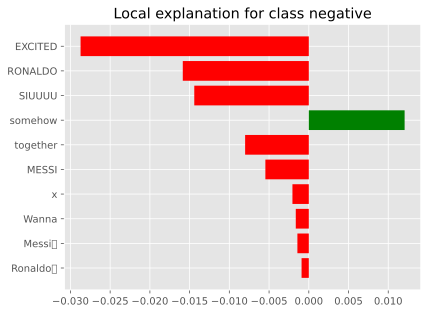

In [49]:
fig = explanation.as_pyplot_figure()

In [50]:
explanation.as_list()[0][1]

-0.0287246380832407